In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy import signal
import matplotlib.pyplot as pl
%matplotlib inline

In [2]:
#Defining Machine parameters 
mach_mc = {"rs": 0.1729, "lq": 0.6986, "ld": 0.4347, "tmech":50.0, "psi_rm":0.9}
# mach_mc = {"rs": 0.009, "ld": 4.14, "lq": 4.21, "tmech":509.6, "psi_rm": 0.5}

# mach_mb = {"rs": 0.0185, "rr": 0.0132, "lh": 3.81, "ls": 3.9, "lr": 3.9, "tmech":397.31}

# mach_ma = {"rs": 0.015, "rr": 0.04, "lh": 2.31, "ls": 2.35, "lr": 2.35, "tmech":596.9}

# mach_BM = {"rs": 0.0426, "rr": 0.02113, "lh": 2.252, "ls": 2.252+0.078, "lr": 2.252+0.1052, "tmech":200.}

###  The Machine Parameters
We use machine dictionaries to calculate the various parameters used in space vector based machine model This function is called mach_para(dict)

In [3]:
def mach_para(mach):
    """Takes in the dictionary containing machine parameters (normalized)
       and returns various parameters that are used in space vector equations
       
       Takes arguement: machine dictionary
       """
    rs = mach["rs"]
    ld = mach['ld']
    lq = mach['lq']
#     ws = mach['ws']
#     sig= 1-(lh*lh)/(lr*ls)
#     kr=lh/lr
#     sigls=sig*ls
#     tr=lr/rr
#     rk=(rs+(kr)*(kr)*rr)
#     tk=sigls/(rs+(kr)*(kr)*rr)
    tmech = mach['tmech']
    psi_rm = mach['psi_rm']
#     print("lh = {0:1.3f}".format(lh))
#     return rs,rr,lh,ls,lr,sig,kr,tr,rk,tk,tmech
    return rs, ld, lq, tmech, psi_rm

In [4]:
mach_para(mach_mc)

(0.1729, 0.4347, 0.6986, 50.0, 0.9)

### PMSM Dynamics
#### Building the Dynamic Model of a PMSM in the d-q Coordinate
To model a PMSM, two state variables are chosen, which are $i_{s}$ and $\omega_{s}$. The $i_{s}$ can be further decomposed to $i_{sd}$, $i_{sq}$ in the permanant magnetic field since it is a complex space vector. The differential equations of these vectors are given as:

\begin{align}
\frac{di_{sd}}{d\tau}&= -\frac{r_{s}}{l_{d}}i_{sd} + \omega_{s} \frac{l_q}{l_d}i_{sq} + \frac{v_{sd}}{l_d}\\
\frac{di_{sq}}{d\tau}&= - \omega_{s} \frac{l_d}{l_q}i_{sd} -\frac{r_{s}}{l_{q}}i_{sq}  - \omega_{s} \frac{\psi_{r,m}}{l_q} + \frac{v_{sq}}{l_q}\\
\frac{d\omega_s}{d\tau}&= \frac{1}{\tau_{mech}}\left[m_e - m_L\right], m_e = \psi_{r,m}i_{sq}+(l_d-l_q)i_{sd}i_{sq}
\end{align}


In [5]:
#Induction machine 5x5 dynamic model 

def IM_dynstep(X,t,params):
    """Defines a function to calculate the derivatives for a 5x5 Induction motor dynamice
       1. Uses state variables stator current $\vec{i}_s$ and rotor flux space vector $\vec{\psi}_r$.
       2. Is non-linear and uses the state variable $\omega$ rotor angular velocity to describe
          rotor dynamics
       3. calls mach_im function to calculate the system equation coefficients
       4. mach_im will in  turn call mach_para function.
       5. uses normalized time 2*np.pi*50*t
       6. This is to be used in a for loop for the time span
    """
    x0 = X[0] #isd
    x1 = X[1] #isq
    ws = X[2] # w
#     x2 = X[2]  #psiralpha
#     x3 = X[3]  #psirbeta
#     x4 = X[4]  #w
#     wx = X[5]
#     u1,u2,m_l,w_s,psi_rm, l_d, l_q = params
    u1,u2,m_l,w_s = params
    rs,l_d,l_q, tmech, psi_rm = mach_para(mach_mc)
#     print("u1:")
#     print(u1)
    
    A,B,C,D,tm = mach_imstep(mach_mc, params)
#     print("B[0]:")
#     print(B[0])
    m_diff = (psi_rm*x0+(l_d-l_q)*x0*x1) - m_l
    dx0_dt = (A[0][0]*x0 + A[0][1]*x1 + A[0][2]*ws + B[0][0]*u1)
    dx1_dt = (A[0][0]*x0 + A[0][1]*x1 + A[0][2]*ws + B[1][0]*(-w_s*psi_rm+u2))
    dx2_dt = (A[0][0]*x0 + A[0][1]*x1 + A[0][2]*ws + B[2][0]*m_diff)
#     print(A[1][0],A[1][1],A[1][2],A[1][3],B[4][0])
#     dx0dt = (A[0][0]*x0 + A[0][1]*x1 + A[0][2]*x2 + A[0][3]*x3*x4 + A[0][4]*x4 + B[0][0]*u1)
#     dx1dt = (A[1][0]*x0 + A[1][1]*x1 + A[1][2]*x2*x4 + A[1][3]*x3 + A[1][4]*x4 + B[1][0]*u2)
#     dx4dt = (A[4][0]*x0 + A[4][1]*x1 + A[4][2]*x2 + A[4][3]*x3 + A[4][4]*x4 + B[4][0]*mdiff)
#     dx2dt = (A[2][0]*x0 + A[2][1]*x1 + A[2][2]*x2 + A[2][3]*x3*x4 + A[2][4]*x4 + 0)
#     dx3dt = (A[3][0]*x0 + A[3][1]*x1 + A[3][2]*x2*x4 + A[3][3]*x3 + A[3][4]*x4 + 0)
#     dx4dt = (A[4][0]*x0 + A[4][1]*x1 + A[4][2]*x2 + A[4][3]*x3 + A[4][4]*x4 + B[4][0]*mdiff)
#     dwxdt = rate
    return [dx0_dt,dx1_dt,dx2_dt]


def mach_imstep(mc_dict, params):
    """
    Define the induction model that is a 3x3 matrix. 
    1. The current components are $i_s\alpha + ji_{s \beta}$. 
    2. The rotor flux components are $\psi_{s\alpha} + j\psi_{s\beta}$ and $\omega$
    3. Needs machine dictionary as input
    4. does not use $\omega_s$ in this function, it will be multipied in the derivative function
    """
    u1,u2,m_l,ws = params
#     rs,rr,ld,lq,sig,kr,tr,rk,tk,tmech = mach_para(mc_dict)
    rs,ld,lq, tmech, psi_rm = mach_para(mc_dict)
    a11 = -(rs/ld)
    a12 = ((ws*lq)/ld)
    a13 = 0
#     a14 = (kr/(sig*ls))   #has to be multiplied by omega
#     a15 = 0


    a21 = -((ld*ws)/lq)
    a22 = -rs/lq
    a23 = 0
#     a24 = a13
#     a25 = 0

    a31 = 0
    a32 = 0 
    a33 = 0

    b11 = 1/(ld)
    b21 = 1/(lq)
    b31 = 1/(tmech)
#     b41 = 0
#     b51 = 1/(tmech)
    

    c11 = 1.0
    c22 = 1.0
    c33 = 1.0
#     c44 = 1.0
#     c55 = 1.0

    A = ([a11,a12,a13],[a21,a22,a23],[a31,a32,a33])
    B = ([b11], [b21], [b31])
    C = ([c11, c22, c33])
    D= ([0,0], [0,0],[0,0],[0,0],[0,0])
#     C=([c11,0,0],[0,c22,0],[0,0,c33])
#     D= ([0,0], [0,0],[0,0],[0,0],[0,0])
#     A=([a11,a12,a13,a14,a15],[a21,a22,a23,a24,a25],[a31,a32,a33,a34,a35],[a41,a42,a43,a44,a45,[a51,a52,a53,a54,a55])
#     B=([b11,0],[b21,0],[b31,0],[b41,0],[b51,0])
#     C=([c11,0,0,0,0],[0,c22,0,0,0],[0,0,c33,0,0],[0,0,0,c44,0],[0,0,0,0,a55])
#     D= ([0,0], [0,0],[0,0],[0,0],[0,0])
    
    return A, B, C, D, tmech

In [6]:
#Rotor dynamics as mechanics
def rotor_dyndq(X,t,params):
    w = X[0]
    gamma = X[1] #rotor angle
    
    me,mL,tmech = params
    dwdt = (me-mL)/tmech
    dgammadt = w
    return [dwdt, dgammadt]
    

In [7]:
#Function for rotor angle integration 
# d\delta/dt = w

def rotorangle(X,t,params):
    del0 = X
    w = params
    ddel0dt = w
    return ddel0dt

In [8]:
def PIcon(xe,y,dt,Kparams):
    """Pass on xe = [error[k], error[k-1]]
       Pass on y  = [y[k-1]]
       Pass on Parameters = [kp, Ti]
    """
    kp, Ti = Kparams
    xeo = xe[1]
    xen = xe[0]
#     print(xeo,xen,y,kp,Ti)
    y1 = y
    y2 = y1 + kp*(xen - xeo) + (kp/Ti)*(xen)
    return y2

def PIconwithLim(xe,y,dt,Kparams):
    """Pass on xe = [error[k], error[k-1]]
       Pass on y  = [y[k-1]]
       Pass on Parameters = [kp, Ti]
    """
    kp, Ti, uplim, dwnlim = Kparams
    xeo = xe[1]
    xen = xe[0]
#     print(xeo,xen,y,kp,Ti)
#     y2 = y1 + kp*(xen - xeo) + (kp/Ti)*(xen)
#     print(xeo,xen,y,kp,Ti)
    y1 = y
    yx = y1 + kp*(xen - xeo) + (kp/Ti)*(xen)
    if (yx > uplim):
        yx = uplim
    elif (yx < dwnlim):
        yx = dwnlim
    y2 = yx
    return y2

## 1. System Dynamics without Control

## 2. System Dynamics with Control

## 3. Controlling the System by Vector Control to Speed up, Keep Steady Speed, and Slowing Down $\omega_s$

In [9]:
#Induction machine 5x5 dynamic model 

def PMSM_dynStep2By2(X,t,params):
    """Defines a function to calculate the derivatives for a 5x5 Induction motor dynamice
       1. Uses state variables stator current $\vec{i}_s$ and rotor flux space vector $\vec{\psi}_r$.
       2. Is non-linear and uses the state variable $\omega$ rotor angular velocity to describe
          rotor dynamics
       3. calls mach_im function to calculate the system equation coefficients
       4. mach_im will in  turn call mach_para function.
       5. uses normalized time 2*np.pi*50*t
       6. This is to be used in a for loop for the time span
    """
    x0 = X[0] #isd
    x1 = X[1] #isq
#     x2 = X[2]  #psiralpha
#     x3 = X[3]  #psirbeta
#     x4 = X[4]  #w
#     wx = X[5]
#     u1,u2,m_l,w_s,psi_rm, l_d, l_q = params
    u1,u2,m_l,w_s = params
    rs,l_d,l_q, tmech, psi_rm = mach_para(mach_mc)
#     print("u1:")
#     print(u1)
    
    A,B,C,D,tm = mach_PMSMStep2By2(mach_mc, params)
#     print("B[0]:")
#     print(B[0])
    m_diff = (psi_rm*x0+(l_d-l_q)*x0*x1) - m_l
    dx0_dt = (A[0][0]*x0 + A[0][1]*x1 + B[0][0]*u1)
    dx1_dt = (A[0][0]*x0 + A[0][1]*x1+ B[1][0]*(-w_s*psi_rm+u2))
#     dx2_dt = (A[0][0]*x0 + A[0][1]*x1 + A[0][2]*ws + B[2][0]*m_diff)

    return [dx0_dt,dx1_dt]


def mach_PMSMStep2By2(mc_dict, params):
    """
    Define the induction model that is a 3x3 matrix. 
    1. The current components are $i_s\alpha + ji_{s \beta}$. 
    2. The rotor flux components are $\psi_{s\alpha} + j\psi_{s\beta}$ and $\omega$
    3. Needs machine dictionary as input
    4. does not use $\omega_s$ in this function, it will be multipied in the derivative function
    """
    u1,u2,m_l,ws = params
#     rs,rr,ld,lq,sig,kr,tr,rk,tk,tmech = mach_para(mc_dict)
    rs,ld,lq, tmech, psi_rm = mach_para(mc_dict)
    a11 = -(rs/ld)
    a12 = ((ws*lq)/ld)
#     a13 = 0
#     a14 = (kr/(sig*ls))   #has to be multiplied by omega
#     a15 = 0


    a21 = -((ld*ws)/lq)
    a22 = -rs/lq
#     a23 = 0
#     a24 = a13
#     a25 = 0

    a31 = 0
    a32 = 0 
#     a33 = 0

    b11 = 1/(ld)
    b21 = 1/(lq)
#     b31 = 1/(tmech)
#     b41 = 0
#     b51 = 1/(tmech)
    

    c11 = 1.0
    c22 = 1.0
#     c33 = 1.0
#     c44 = 1.0
#     c55 = 1.0
    A = ([a11,a12],[a21,a22],[a31,a32])
    B = ([b11], [b21])
    C = ([c11, c22])
    D= ([0,0],[0,0])
#     A = ([a11,a12,a13],[a21,a22,a23],[a31,a32,a33])
#     B = ([b11], [b21], [b31])
#     C = ([c11, c22, c33])
#     D= ([0,0], [0,0],[0,0],[0,0],[0,0])
#     C=([c11,0,0],[0,c22,0],[0,0,c33])
#     D= ([0,0], [0,0],[0,0],[0,0],[0,0])
#     A=([a11,a12,a13,a14,a15],[a21,a22,a23,a24,a25],[a31,a32,a33,a34,a35],[a41,a42,a43,a44,a45,[a51,a52,a53,a54,a55])
#     B=([b11,0],[b21,0],[b31,0],[b41,0],[b51,0])
#     C=([c11,0,0,0,0],[0,c22,0,0,0],[0,0,c33,0,0],[0,0,0,c44,0],[0,0,0,0,a55])
#     D= ([0,0], [0,0],[0,0],[0,0],[0,0])
    
    return A, B, C, D, tmech

In [10]:
#Rotor dynamics as mechanics
def rotor_dyndq(X,t,params):
    w = X[0]
    gamma = X[1] #rotor angle
    
    me,mL,tmech = params
    dwdt = (me-mL)/tmech
    dgammadt = w
    return [dwdt, dgammadt]

    if w < -zeroThresh:
        # a > 0 to slow down, # a < 0 to speed up:
        if(isSlowingDown == 1):
            isd = 0.85
            isq = -1
        else:
            isd = -0.85
            isq = -1
    else:
        # a < 0 to slow down, # a < 0 to speed up:
        if(isSlowingDown == 1):
            isd = -0.85
            isq = -1
        else:
            isd = 0.85
            isq = -1

In [23]:
zeroThresh = 0.0005
def calculateIsdIsqRefsBySpeedSimple(w, isSlowingDown):
    isd, isq = 0.0, 0.0
    a = 0.0199
    ml = 0.0
    if w < -zeroThresh:
        # a > 0 to slow down, # a < 0 to speed up:
        if(isSlowingDown == 1):
            isd = -1 # a = 0.0199
            isq = 0.85
        else:
            isd = -1 # a = -0.0199
            isq = -0.85
    else:
        # a < 0 to slow down, # a > 0 to speed up:
        if(isSlowingDown == 1):
            isd = -1
            isq = -0.85
        else:
            isd = -1
            isq = 0.85
#     else:
#         isd, isq = 0.0, 0.0
#     if isSlowingDown < 0:
#         # slowing down:
#         isd = 0.5
#         isq = -0.09
#     else:
#         # speeding up
#         isd = 0.2
#         isq = 0.105
    print("calculate isd, isq:")
    print(isd, isq)
    return isd, isq
        

In [25]:
def braking(w, isSlowingDown):
    print("in braking")
    print(w)
    isd, isq = 0.0, 0.0
    if(abs(w) <= zeroThresh):
        isd, isq = 0.0, 0.0
    else:
        isd, isq = calculateIsdIsqRefsBySpeedSimple(w, 1)
    print("braking: isd, isq:")
    print(isd, isq)
    return isd, isq

In [29]:
def simulateSpeedingUpWithAcceleration():
    #Setting up the simulaton for rotor model
    # We will use for loop for simulation 
    rs, ld, lq, tmech, psi_rm  = mach_para(mach_mc)
    tend = 20*3*np.pi
    tstart = 0.0
    delta_t = 0.01
    Tta = np.arange(tstart, tend,delta_t)
    # ODE solver parameters
    abserr = 1.0e-8
    relerr = 1.0e-3
    
    n = 100000
#     n2 = int(100*2*np.pi/0.01)
    # ws = -0.5
    ws = -0.5
    # Initializing ws:
#     a = 0.0001 # angular acceleration
#     for i in range(1, len(Tta)):
#         new_ws = ws[i-1]+a
#         if(new_ws > 1):
#             ws[i] = 1
#         else:
#             ws[i] = new_ws
    mL = 0.0
    # Tta = np.linspace(tstart, tend, n2)
    #delta_t = Tta[1] - Tta[0]
    usd = np.zeros(len(Tta))
    usq = np.zeros(len(Tta))
    sol1 = np.zeros((len(Tta),2))
    sol2 = np.zeros((len(Tta),2))
    FCangle = np.zeros(len(Tta))
    gamma = np.zeros(len(Tta)) # rotor angle
    # Field coordinate currents
    cosdelta = np.zeros(len(Tta))
    sindelta = np.zeros(len(Tta))
    isd = np.zeros(len(Tta))
    isq = np.zeros(len(Tta))
    eid = np.zeros(len(Tta))
    eiq = np.zeros(len(Tta))
    w = np.zeros(len(Tta))

    me = np.zeros(len(Tta))
    x0 = [0,0] # isd, isq, ws
    y0 = [0,0] # w, angle

    kpd = ld*1
    Tid = 25.0e1

    kpq = lq*2
    Tiq = 25.0e1

    Kparamsd = [kpd,Tid]
    Kparamsq = [kpq,Tiq]
    flag = 0

#     for ii in range(0, len(Tta))
    ii =0
    isdref = 0.0
    isqref = 0.0
    isdrefs = [isdref]
    isqrefs = [isqref]
    endOfStablization = 0
    while(ii < len(Tta)):      
        #Start controller after first step
        if ii>=0:
            eid[ii] = isdref - isd[ii-1]
            PIed = [eid[ii],eid[ii-1]]
            usd[ii] = PIcon(PIed, usd[ii-1], delta_t,Kparamsd) 
            eiq[ii] = isqref - isq[ii-1]
            PIeq = [eiq[ii],eiq[ii-1]]
            usq[ii] = PIcon(PIeq, usq[ii-1], delta_t,Kparamsq)

        # solve for the state variables: isd, isq
        params = [usd[ii], usq[ii],w[ii], ws]
        sol1a = odeint(PMSM_dynStep2By2,x0,[0,delta_t], args = (params,),atol = abserr, rtol= relerr)
        sol1[ii]= sol1a[-1]
        x0 = sol1a[-1]
        isd[ii] = sol1[ii][0]
        isq[ii] = sol1[ii][1]
        # solve for w:
        me[ii] = 1.0*sol1[ii][1] + (ld -lq)*sol1[ii][0]*sol1[ii][1]
        paramsw = [me[ii],0.0,tmech]
        sol2a = odeint(rotor_dyndq, y0, [0,delta_t], args = (paramsw,), atol = abserr, rtol= relerr)
        y0 = sol2a[-1]
        sol2[ii] = sol2a[-1]
        FCangle[ii] = sol2[ii][1]
        gamma[ii] = sol2[ii][1]
        w[ii] = sol2[ii][0]
#         TtaEnd = Tta[ii]
        print("w[ii]:")
        print(ii, Tta[ii], w[ii])
        print("New")
        if(ii < len(Tta) and Tta[ii] >= 2*np.pi and Tta[ii] < 15*np.pi):
            print("Speeding up from:")
            print(Tta[ii])
            isdref, isqref = calculateIsdIsqRefsBySpeedSimple(w[ii], 0)
            isdrefs.append(isdref)
            isqrefs.append(isqref)
        elif(ii < len(Tta) and Tta[ii] >= 15*np.pi and Tta[ii] < 35*np.pi):
            print("Uniform speed from:")
            print(Tta[ii])
            isdref = 0
            isqref = 0
            isdrefs.append(isdref)
            isqrefs.append(isqref)
        else:
            print("Before Braking: w:")
            print(w[ii])
            print(Tta[ii])
            isdref, isqref = calculateIsdIsqRefsBySpeedSimple(w[ii], 1)
            isdrefs.append(isdref)
            isqrefs.append(isqref)
        ii += 1
    rs,l_d,l_q, tmech, psi_rm = mach_para(mach_mc)
#     me = psi_rm*isq + (l_d-l_q)*isd*isq # get torque
    return Tta, w, me, isd, isq, np.array(isdrefs)[0:len(Tta)], np.array(isqrefs)[0:len(Tta)]

In [30]:
# import matplotlib.pyplot as pl
# %matplotlib inline
def plotDynamicForSpeedingUp(Tta, w1, me1, isd1, isq1, isdref, isqref):
    pl.figure(531, figsize = (6,6))
    pl.rc('font', size = 16)
    # plot the isd and isq
    pl.subplot(2,1,1)
    pl.plot(Tta,  isd, 'purple', Tta, isdref,'skyblue', lw=3)
    pl.plot(Tta, isqref,'tomato', Tta,isq ,'crimson' ,lw =2)

    pl.xlim(0,Tta[-1])
    pl.ylabel(r'$isd, isq$' )
    pl.xticks(np.linspace(0,Tta[-1],5))

    ax1 = pl.subplot(2,1,2)
    ax1.axhline(0)
    ax1.plot(Tta, me1, 'crimson', lw =2)
    ax1.set_yticks(np.linspace(-1.0,1.0,5))
    ax1.set_ylabel('me [p.u]')
    ax2 = ax1.twinx()
    ax2.set_ylabel('$\omega$')
    ax2.plot(Tta,w, 'peru', lw =3)

w[ii]:
0 0.0 1.2831457301089506e-06
New
Before Braking: w:
1.2831457301089506e-06
0.0
calculate isd, isq:
-1 -0.85
w[ii]:
1 0.01 4.152665345786167e-07
New
Before Braking: w:
4.152665345786167e-07
0.01
calculate isd, isq:
-1 -0.85
w[ii]:
2 0.02 -2.5602978004417255e-06
New
Before Braking: w:
-2.5602978004417255e-06
0.02
calculate isd, isq:
-1 -0.85
w[ii]:
3 0.03 -7.600930023722065e-06
New
Before Braking: w:
-7.600930023722065e-06
0.03
calculate isd, isq:
-1 -0.85
w[ii]:
4 0.04 -1.4664769467995567e-05
New
Before Braking: w:
-1.4664769467995567e-05
0.04
calculate isd, isq:
-1 -0.85
w[ii]:
5 0.05 -2.3710726212115753e-05
New
Before Braking: w:
-2.3710726212115753e-05
0.05
calculate isd, isq:
-1 -0.85
w[ii]:
6 0.06 -3.469848036213169e-05
New
Before Braking: w:
-3.469848036213169e-05
0.06
calculate isd, isq:
-1 -0.85
w[ii]:
7 0.07 -4.758847944241968e-05
New
Before Braking: w:
-4.758847944241968e-05
0.07
calculate isd, isq:
-1 -0.85
w[ii]:
8 0.08 -6.23419344864028e-05
New
Before Braking: w:
-6.

New
Before Braking: w:
-0.00047658146507649274
1.68
calculate isd, isq:
-1 -0.85
w[ii]:
169 1.69 -0.0004903744918050151
New
Before Braking: w:
-0.0004903744918050151
1.69
calculate isd, isq:
-1 -0.85
w[ii]:
170 1.7 -0.0005066635507434188
New
Before Braking: w:
-0.0005066635507434188
1.7
calculate isd, isq:
-1 0.85
w[ii]:
171 1.71 -0.0005171214492328533
New
Before Braking: w:
-0.0005171214492328533
1.71
calculate isd, isq:
-1 0.85
w[ii]:
172 1.72 -0.0005218890944392255
New
Before Braking: w:
-0.0005218890944392255
1.72
calculate isd, isq:
-1 0.85
w[ii]:
173 1.73 -0.0005211031597671409
New
Before Braking: w:
-0.0005211031597671409
1.73
calculate isd, isq:
-1 0.85
w[ii]:
174 1.74 -0.0005148962797972216
New
Before Braking: w:
-0.0005148962797972216
1.74
calculate isd, isq:
-1 0.85
w[ii]:
175 1.75 -0.0005033968305669912
New
Before Braking: w:
-0.0005033968305669912
1.75
calculate isd, isq:
-1 0.85
w[ii]:
176 1.76 -0.00048672951167349696
New
Before Braking: w:
-0.00048672951167349696
1.76
ca

-0.0004988296902234462
5.67
calculate isd, isq:
-1 -0.85
w[ii]:
568 5.68 -0.0004967749582319148
New
Before Braking: w:
-0.0004967749582319148
5.68
calculate isd, isq:
-1 -0.85
w[ii]:
569 5.69 -0.0004987325744973957
New
Before Braking: w:
-0.0004987325744973957
5.69
calculate isd, isq:
-1 -0.85
w[ii]:
570 5.7 -0.000504607386202298
New
Before Braking: w:
-0.000504607386202298
5.7
calculate isd, isq:
-1 0.85
w[ii]:
571 5.71 -0.0005057149712306317
New
Before Braking: w:
-0.0005057149712306317
5.71
calculate isd, isq:
-1 0.85
w[ii]:
572 5.72 -0.0005021714368976598
New
Before Braking: w:
-0.0005021714368976598
5.72
calculate isd, isq:
-1 0.85
w[ii]:
573 5.73 -0.0004940892230481334
New
Before Braking: w:
-0.0004940892230481334
5.73
calculate isd, isq:
-1 -0.85
w[ii]:
574 5.74 -0.0004901705722406787
New
Before Braking: w:
-0.0004901705722406787
5.74
calculate isd, isq:
-1 -0.85
w[ii]:
575 5.75 -0.0004903167916489166
New
Before Braking: w:
-0.0004903167916489166
5.75
calculate isd, isq:
-1 -0.8

-1 -0.85
w[ii]:
954 9.540000000000001 -0.050831455593783624
New
Speeding up from:
9.540000000000001
calculate isd, isq:
-1 -0.85
w[ii]:
955 9.55 -0.05101959283353968
New
Speeding up from:
9.55
calculate isd, isq:
-1 -0.85
w[ii]:
956 9.56 -0.05120778590615535
New
Speeding up from:
9.56
calculate isd, isq:
-1 -0.85
w[ii]:
957 9.57 -0.05139603460668113
New
Speeding up from:
9.57
calculate isd, isq:
-1 -0.85
w[ii]:
958 9.58 -0.05158433873211659
New
Speeding up from:
9.58
calculate isd, isq:
-1 -0.85
w[ii]:
959 9.59 -0.05177269808138531
New
Speeding up from:
9.59
calculate isd, isq:
-1 -0.85
w[ii]:
960 9.6 -0.05196111245531017
New
Speeding up from:
9.6
calculate isd, isq:
-1 -0.85
w[ii]:
961 9.61 -0.05214958165658909
New
Speeding up from:
9.61
calculate isd, isq:
-1 -0.85
w[ii]:
962 9.620000000000001 -0.05233810548977108
New
Speeding up from:
9.620000000000001
calculate isd, isq:
-1 -0.85
w[ii]:
963 9.63 -0.052526683761232824
New
Speeding up from:
9.63
calculate isd, isq:
-1 -0.85
w[ii]:
96

1183 11.83 -0.09510522819967614
New
Speeding up from:
11.83
calculate isd, isq:
-1 -0.85
w[ii]:
1184 11.84 -0.09530300305365061
New
Speeding up from:
11.84
calculate isd, isq:
-1 -0.85
w[ii]:
1185 11.85 -0.09550081148996543
New
Speeding up from:
11.85
calculate isd, isq:
-1 -0.85
w[ii]:
1186 11.86 -0.09569865345817075
New
Speeding up from:
11.86
calculate isd, isq:
-1 -0.85
w[ii]:
1187 11.870000000000001 -0.0958965289079399
New
Speeding up from:
11.870000000000001
calculate isd, isq:
-1 -0.85
w[ii]:
1188 11.88 -0.0960944377890676
New
Speeding up from:
11.88
calculate isd, isq:
-1 -0.85
w[ii]:
1189 11.89 -0.09629238005146826
New
Speeding up from:
11.89
calculate isd, isq:
-1 -0.85
w[ii]:
1190 11.9 -0.0964903556451743
New
Speeding up from:
11.9
calculate isd, isq:
-1 -0.85
w[ii]:
1191 11.91 -0.09668836452033458
New
Speeding up from:
11.91
calculate isd, isq:
-1 -0.85
w[ii]:
1192 11.92 -0.09688640662721262
New
Speeding up from:
11.92
calculate isd, isq:
-1 -0.85
w[ii]:
1193 11.93 -0.09708

w[ii]:
1415 14.15 -0.141793686762471
New
Speeding up from:
14.15
calculate isd, isq:
-1 -0.85
w[ii]:
1416 14.16 -0.14199803267981498
New
Speeding up from:
14.16
calculate isd, isq:
-1 -0.85
w[ii]:
1417 14.17 -0.14220240191697203
New
Speeding up from:
14.17
calculate isd, isq:
-1 -0.85
w[ii]:
1418 14.18 -0.14240679443271384
New
Speeding up from:
14.18
calculate isd, isq:
-1 -0.85
w[ii]:
1419 14.19 -0.1426112101858355
New
Speeding up from:
14.19
calculate isd, isq:
-1 -0.85
w[ii]:
1420 14.200000000000001 -0.14281564913515554
New
Speeding up from:
14.200000000000001
calculate isd, isq:
-1 -0.85
w[ii]:
1421 14.21 -0.14302011123951597
New
Speeding up from:
14.21
calculate isd, isq:
-1 -0.85
w[ii]:
1422 14.22 -0.14322459645778257
New
Speeding up from:
14.22
calculate isd, isq:
-1 -0.85
w[ii]:
1423 14.23 -0.14342910474884504
New
Speeding up from:
14.23
calculate isd, isq:
-1 -0.85
w[ii]:
1424 14.24 -0.14363363607161705
New
Speeding up from:
14.24
calculate isd, isq:
-1 -0.85
w[ii]:
1425 14.25

calculate isd, isq:
-1 -0.85
w[ii]:
1704 17.04 -0.20166503018319973
New
Speeding up from:
17.04
calculate isd, isq:
-1 -0.85
w[ii]:
1705 17.05 -0.20187453388290616
New
Speeding up from:
17.05
calculate isd, isq:
-1 -0.85
w[ii]:
1706 17.06 -0.20208405051244227
New
Speeding up from:
17.06
calculate isd, isq:
-1 -0.85
w[ii]:
1707 17.07 -0.20229358004261247
New
Speeding up from:
17.07
calculate isd, isq:
-1 -0.85
w[ii]:
1708 17.080000000000002 -0.2025031224442727
New
Speeding up from:
17.080000000000002
calculate isd, isq:
-1 -0.85
w[ii]:
1709 17.09 -0.20271267768833068
New
Speeding up from:
17.09
calculate isd, isq:
-1 -0.85
w[ii]:
1710 17.1 -0.20292224574574572
New
Speeding up from:
17.1
calculate isd, isq:
-1 -0.85
w[ii]:
1711 17.11 -0.20313182658752857
New
Speeding up from:
17.11
calculate isd, isq:
-1 -0.85
w[ii]:
1712 17.12 -0.20334142018474183
New
Speeding up from:
17.12
calculate isd, isq:
-1 -0.85
w[ii]:
1713 17.13 -0.20355102650849957
New
Speeding up from:
17.13
calculate isd, is

w[ii]:
1904 19.04 -0.24378802282688278
New
Speeding up from:
19.04
calculate isd, isq:
-1 -0.85
w[ii]:
1905 19.05 -0.24399959797264087
New
Speeding up from:
19.05
calculate isd, isq:
-1 -0.85
w[ii]:
1906 19.06 -0.24421118120395757
New
Speeding up from:
19.06
calculate isd, isq:
-1 -0.85
w[ii]:
1907 19.07 -0.24442277250134398
New
Speeding up from:
19.07
calculate isd, isq:
-1 -0.85
w[ii]:
1908 19.080000000000002 -0.2446343718453545
New
Speeding up from:
19.080000000000002
calculate isd, isq:
-1 -0.85
w[ii]:
1909 19.09 -0.24484597921658663
New
Speeding up from:
19.09
calculate isd, isq:
-1 -0.85
w[ii]:
1910 19.1 -0.24505759459568102
New
Speeding up from:
19.1
calculate isd, isq:
-1 -0.85
w[ii]:
1911 19.11 -0.2452692179633213
New
Speeding up from:
19.11
calculate isd, isq:
-1 -0.85
w[ii]:
1912 19.12 -0.24548084930023412
New
Speeding up from:
19.12
calculate isd, isq:
-1 -0.85
w[ii]:
1913 19.13 -0.24569248858718887
New
Speeding up from:
19.13
calculate isd, isq:
-1 -0.85
w[ii]:
1914 19.14 

2355 23.55 -0.3397960002334744
New
Speeding up from:
23.55
calculate isd, isq:
-1 -0.85
w[ii]:
2356 23.56 -0.34000978490357014
New
Speeding up from:
23.56
calculate isd, isq:
-1 -0.85
w[ii]:
2357 23.57 -0.34022357223609945
New
Speeding up from:
23.57
calculate isd, isq:
-1 -0.85
w[ii]:
2358 23.580000000000002 -0.3404373622244715
New
Speeding up from:
23.580000000000002
calculate isd, isq:
-1 -0.85
w[ii]:
2359 23.59 -0.340651154862112
New
Speeding up from:
23.59
calculate isd, isq:
-1 -0.85
w[ii]:
2360 23.6 -0.34086495014246276
New
Speeding up from:
23.6
calculate isd, isq:
-1 -0.85
w[ii]:
2361 23.61 -0.34107874805898203
New
Speeding up from:
23.61
calculate isd, isq:
-1 -0.85
w[ii]:
2362 23.62 -0.34129254860514413
New
Speeding up from:
23.62
calculate isd, isq:
-1 -0.85
w[ii]:
2363 23.63 -0.3415063517744398
New
Speeding up from:
23.63
calculate isd, isq:
-1 -0.85
w[ii]:
2364 23.64 -0.34172015756037555
New
Speeding up from:
23.64
calculate isd, isq:
-1 -0.85
w[ii]:
2365 23.6500000000000

calculate isd, isq:
-1 -0.85
w[ii]:
2754 27.54 -0.4252523904567854
New
Speeding up from:
27.54
calculate isd, isq:
-1 -0.85
w[ii]:
2755 27.55 -0.42546685088974706
New
Speeding up from:
27.55
calculate isd, isq:
-1 -0.85
w[ii]:
2756 27.560000000000002 -0.4256813123148775
New
Speeding up from:
27.560000000000002
calculate isd, isq:
-1 -0.85
w[ii]:
2757 27.57 -0.42589577472973
New
Speeding up from:
27.57
calculate isd, isq:
-1 -0.85
w[ii]:
2758 27.580000000000002 -0.42611023813186416
New
Speeding up from:
27.580000000000002
calculate isd, isq:
-1 -0.85
w[ii]:
2759 27.59 -0.42632470251884524
New
Speeding up from:
27.59
calculate isd, isq:
-1 -0.85
w[ii]:
2760 27.6 -0.42653916788824475
New
Speeding up from:
27.6
calculate isd, isq:
-1 -0.85
w[ii]:
2761 27.61 -0.4267536342376401
New
Speeding up from:
27.61
calculate isd, isq:
-1 -0.85
w[ii]:
2762 27.62 -0.42696810156461473
New
Speeding up from:
27.62
calculate isd, isq:
-1 -0.85
w[ii]:
2763 27.63 -0.427182569866758
New
Speeding up from:
27.6

2956 29.560000000000002 -0.4685905985338029
New
Speeding up from:
29.560000000000002
calculate isd, isq:
-1 -0.85
w[ii]:
2957 29.57 -0.46880521697613076
New
Speeding up from:
29.57
calculate isd, isq:
-1 -0.85
w[ii]:
2958 29.580000000000002 -0.4690198360210901
New
Speeding up from:
29.580000000000002
calculate isd, isq:
-1 -0.85
w[ii]:
2959 29.59 -0.4692344556671955
New
Speeding up from:
29.59
calculate isd, isq:
-1 -0.85
w[ii]:
2960 29.6 -0.4694490759129658
New
Speeding up from:
29.6
calculate isd, isq:
-1 -0.85
w[ii]:
2961 29.61 -0.4696636967569231
New
Speeding up from:
29.61
calculate isd, isq:
-1 -0.85
w[ii]:
2962 29.62 -0.4698783181975932
New
Speeding up from:
29.62
calculate isd, isq:
-1 -0.85
w[ii]:
2963 29.63 -0.4700929402335055
New
Speeding up from:
29.63
calculate isd, isq:
-1 -0.85
w[ii]:
2964 29.64 -0.47030756286319314
New
Speeding up from:
29.64
calculate isd, isq:
-1 -0.85
w[ii]:
2965 29.650000000000002 -0.4705221860851928
New
Speeding up from:
29.650000000000002
calculat

w[ii]:
3465 34.65 -0.5778846572643831
New
Speeding up from:
34.65
calculate isd, isq:
-1 -0.85
w[ii]:
3466 34.660000000000004 -0.5780994508485976
New
Speeding up from:
34.660000000000004
calculate isd, isq:
-1 -0.85
w[ii]:
3467 34.67 -0.578314244604968
New
Speeding up from:
34.67
calculate isd, isq:
-1 -0.85
w[ii]:
3468 34.68 -0.578529038533054
New
Speeding up from:
34.68
calculate isd, isq:
-1 -0.85
w[ii]:
3469 34.69 -0.5787438326324168
New
Speeding up from:
34.69
calculate isd, isq:
-1 -0.85
w[ii]:
3470 34.7 -0.5789586269026192
New
Speeding up from:
34.7
calculate isd, isq:
-1 -0.85
w[ii]:
3471 34.71 -0.5791734213432254
New
Speeding up from:
34.71
calculate isd, isq:
-1 -0.85
w[ii]:
3472 34.72 -0.5793882159538012
New
Speeding up from:
34.72
calculate isd, isq:
-1 -0.85
w[ii]:
3473 34.730000000000004 -0.579603010733914
New
Speeding up from:
34.730000000000004
calculate isd, isq:
-1 -0.85
w[ii]:
3474 34.74 -0.5798178056831321
New
Speeding up from:
34.74
calculate isd, isq:
-1 -0.85
w[i

-1 -0.85
w[ii]:
3910 39.1 -0.6734799587700709
New
Speeding up from:
39.1
calculate isd, isq:
-1 -0.85
w[ii]:
3911 39.11 -0.673694798739638
New
Speeding up from:
39.11
calculate isd, isq:
-1 -0.85
w[ii]:
3912 39.12 -0.6739096387662633
New
Speeding up from:
39.12
calculate isd, isq:
-1 -0.85
w[ii]:
3913 39.13 -0.6741244788498058
New
Speeding up from:
39.13
calculate isd, isq:
-1 -0.85
w[ii]:
3914 39.14 -0.6743393189901241
New
Speeding up from:
39.14
calculate isd, isq:
-1 -0.85
w[ii]:
3915 39.15 -0.6745541591870777
New
Speeding up from:
39.15
calculate isd, isq:
-1 -0.85
w[ii]:
3916 39.160000000000004 -0.6747689994405263
New
Speeding up from:
39.160000000000004
calculate isd, isq:
-1 -0.85
w[ii]:
3917 39.17 -0.67498383975033
New
Speeding up from:
39.17
calculate isd, isq:
-1 -0.85
w[ii]:
3918 39.18 -0.6751986801163491
New
Speeding up from:
39.18
calculate isd, isq:
-1 -0.85
w[ii]:
3919 39.19 -0.6754135205384445
New
Speeding up from:
39.19
calculate isd, isq:
-1 -0.85
w[ii]:
3920 39.2 -0.

calculate isd, isq:
-1 -0.85
w[ii]:
4275 42.75 -0.7518994169445208
New
Speeding up from:
42.75
calculate isd, isq:
-1 -0.85
w[ii]:
4276 42.76 -0.7521142706312582
New
Speeding up from:
42.76
calculate isd, isq:
-1 -0.85
w[ii]:
4277 42.77 -0.752329124341066
New
Speeding up from:
42.77
calculate isd, isq:
-1 -0.85
w[ii]:
4278 42.78 -0.7525439780738867
New
Speeding up from:
42.78
calculate isd, isq:
-1 -0.85
w[ii]:
4279 42.79 -0.7527588318296634
New
Speeding up from:
42.79
calculate isd, isq:
-1 -0.85
w[ii]:
4280 42.800000000000004 -0.7529736856083393
New
Speeding up from:
42.800000000000004
calculate isd, isq:
-1 -0.85
w[ii]:
4281 42.81 -0.7531885394098576
New
Speeding up from:
42.81
calculate isd, isq:
-1 -0.85
w[ii]:
4282 42.82 -0.7534033932341619
New
Speeding up from:
42.82
calculate isd, isq:
-1 -0.85
w[ii]:
4283 42.83 -0.7536182470811957
New
Speeding up from:
42.83
calculate isd, isq:
-1 -0.85
w[ii]:
4284 42.84 -0.7538331009509025
New
Speeding up from:
42.84
calculate isd, isq:
-1 -0

4526 45.26 -0.8058283304319391
New
Speeding up from:
45.26
calculate isd, isq:
-1 -0.85
w[ii]:
4527 45.27 -0.8060431887683346
New
Speeding up from:
45.27
calculate isd, isq:
-1 -0.85
w[ii]:
4528 45.28 -0.8062580471150536
New
Speeding up from:
45.28
calculate isd, isq:
-1 -0.85
w[ii]:
4529 45.29 -0.806472905472076
New
Speeding up from:
45.29
calculate isd, isq:
-1 -0.85
w[ii]:
4530 45.300000000000004 -0.8066877638393821
New
Speeding up from:
45.300000000000004
calculate isd, isq:
-1 -0.85
w[ii]:
4531 45.31 -0.806902622216952
New
Speeding up from:
45.31
calculate isd, isq:
-1 -0.85
w[ii]:
4532 45.32 -0.8071174806047654
New
Speeding up from:
45.32
calculate isd, isq:
-1 -0.85
w[ii]:
4533 45.33 -0.8073323390028029
New
Speeding up from:
45.33
calculate isd, isq:
-1 -0.85
w[ii]:
4534 45.34 -0.8075471974110443
New
Speeding up from:
45.34
calculate isd, isq:
-1 -0.85
w[ii]:
4535 45.35 -0.8077620558294697
New
Speeding up from:
45.35
calculate isd, isq:
-1 -0.85
w[ii]:
4536 45.36 -0.807976914258

4913 49.13 -0.8604497314988185
New
Uniform speed from:
49.13
w[ii]:
4914 49.14 -0.8604857664806913
New
Uniform speed from:
49.14
w[ii]:
4915 49.15 -0.8605217071220645
New
Uniform speed from:
49.15
w[ii]:
4916 49.160000000000004 -0.8605575540481324
New
Uniform speed from:
49.160000000000004
w[ii]:
4917 49.17 -0.8605933078716487
New
Uniform speed from:
49.17
w[ii]:
4918 49.18 -0.8606289691932452
New
Uniform speed from:
49.18
w[ii]:
4919 49.19 -0.8606645386017431
New
Uniform speed from:
49.19
w[ii]:
4920 49.2 -0.8607000166744551
New
Uniform speed from:
49.2
w[ii]:
4921 49.21 -0.8607354039774792
New
Uniform speed from:
49.21
w[ii]:
4922 49.22 -0.8607707010659847
New
Uniform speed from:
49.22
w[ii]:
4923 49.230000000000004 -0.8608059084844913
New
Uniform speed from:
49.230000000000004
w[ii]:
4924 49.24 -0.8608410267671395
New
Uniform speed from:
49.24
w[ii]:
4925 49.25 -0.8608760564379545
New
Uniform speed from:
49.25
w[ii]:
4926 49.26 -0.8609109980111025
New
Uniform speed from:
49.26
w[ii]

5556 55.56 -0.8725417764199878
New
Uniform speed from:
55.56
w[ii]:
5557 55.57 -0.8725497826388359
New
Uniform speed from:
55.57
w[ii]:
5558 55.58 -0.8725577691444693
New
Uniform speed from:
55.58
w[ii]:
5559 55.59 -0.8725657359834118
New
Uniform speed from:
55.59
w[ii]:
5560 55.6 -0.8725736832020932
New
Uniform speed from:
55.6
w[ii]:
5561 55.61 -0.8725816108468493
New
Uniform speed from:
55.61
w[ii]:
5562 55.620000000000005 -0.8725895189639215
New
Uniform speed from:
55.620000000000005
w[ii]:
5563 55.63 -0.8725974075994578
New
Uniform speed from:
55.63
w[ii]:
5564 55.64 -0.8726052767995124
New
Uniform speed from:
55.64
w[ii]:
5565 55.65 -0.8726131266100452
New
Uniform speed from:
55.65
w[ii]:
5566 55.660000000000004 -0.8726209570769231
New
Uniform speed from:
55.660000000000004
w[ii]:
5567 55.67 -0.8726287682459195
New
Uniform speed from:
55.67
w[ii]:
5568 55.68 -0.8726365601627141
New
Uniform speed from:
55.68
w[ii]:
5569 55.69 -0.8726443328728933
New
Uniform speed from:
55.69
w[ii]

Uniform speed from:
62.160000000000004
w[ii]:
6217 62.17 -0.8751425962099588
New
Uniform speed from:
62.17
w[ii]:
6218 62.18 -0.8751441410848152
New
Uniform speed from:
62.18
w[ii]:
6219 62.190000000000005 -0.8751456821281156
New
Uniform speed from:
62.190000000000005
w[ii]:
6220 62.2 -0.8751472193494286
New
Uniform speed from:
62.2
w[ii]:
6221 62.21 -0.8751487527582985
New
Uniform speed from:
62.21
w[ii]:
6222 62.22 -0.8751502823642454
New
Uniform speed from:
62.22
w[ii]:
6223 62.230000000000004 -0.8751518081767659
New
Uniform speed from:
62.230000000000004
w[ii]:
6224 62.24 -0.8751533302053317
New
Uniform speed from:
62.24
w[ii]:
6225 62.25 -0.8751548484593915
New
Uniform speed from:
62.25
w[ii]:
6226 62.26 -0.8751563629483697
New
Uniform speed from:
62.26
w[ii]:
6227 62.27 -0.8751578736816672
New
Uniform speed from:
62.27
w[ii]:
6228 62.28 -0.8751593806686608
New
Uniform speed from:
62.28
w[ii]:
6229 62.29 -0.8751608839187043
New
Uniform speed from:
62.29
w[ii]:
6230 62.300000000000

65.25
w[ii]:
6526 65.26 -0.8754764692366194
New
Uniform speed from:
65.26
w[ii]:
6527 65.27 -0.8754771876653991
New
Uniform speed from:
65.27
w[ii]:
6528 65.28 -0.8754779043193799
New
Uniform speed from:
65.28
w[ii]:
6529 65.29 -0.875478619202961
New
Uniform speed from:
65.29
w[ii]:
6530 65.3 -0.8754793323205304
New
Uniform speed from:
65.3
w[ii]:
6531 65.31 -0.8754800436764654
New
Uniform speed from:
65.31
w[ii]:
6532 65.32000000000001 -0.8754807532751315
New
Uniform speed from:
65.32000000000001
w[ii]:
6533 65.33 -0.8754814611208843
New
Uniform speed from:
65.33
w[ii]:
6534 65.34 -0.8754821672180683
New
Uniform speed from:
65.34
w[ii]:
6535 65.35 -0.8754828715710165
New
Uniform speed from:
65.35
w[ii]:
6536 65.36 -0.8754835741840518
New
Uniform speed from:
65.36
w[ii]:
6537 65.37 -0.8754842750614863
New
Uniform speed from:
65.37
w[ii]:
6538 65.38 -0.8754849742076208
New
Uniform speed from:
65.38
w[ii]:
6539 65.39 -0.8754856716267457
New
Uniform speed from:
65.39
w[ii]:
6540 65.4 -0.8

71.98
w[ii]:
7199 71.99 -0.8757123862948821
New
Uniform speed from:
71.99
w[ii]:
7200 72.0 -0.8757125225827087
New
Uniform speed from:
72.0
w[ii]:
7201 72.01 -0.8757126585345211
New
Uniform speed from:
72.01
w[ii]:
7202 72.02 -0.8757127941511479
New
Uniform speed from:
72.02
w[ii]:
7203 72.03 -0.8757129294334158
New
Uniform speed from:
72.03
w[ii]:
7204 72.04 -0.8757130643821494
New
Uniform speed from:
72.04
w[ii]:
7205 72.05 -0.875713198998171
New
Uniform speed from:
72.05
w[ii]:
7206 72.06 -0.8757133332823014
New
Uniform speed from:
72.06
w[ii]:
7207 72.07000000000001 -0.8757134672353587
New
Uniform speed from:
72.07000000000001
w[ii]:
7208 72.08 -0.8757136008581593
New
Uniform speed from:
72.08
w[ii]:
7209 72.09 -0.875713734151518
New
Uniform speed from:
72.09
w[ii]:
7210 72.10000000000001 -0.8757138671162469
New
Uniform speed from:
72.10000000000001
w[ii]:
7211 72.11 -0.8757139997531563
New
Uniform speed from:
72.11
w[ii]:
7212 72.12 -0.8757141320630549
New
Uniform speed from:
72.1

w[ii]:
7888 78.88 -0.8757575765224209
New
Uniform speed from:
78.88
w[ii]:
7889 78.89 -0.875757601404454
New
Uniform speed from:
78.89
w[ii]:
7890 78.9 -0.8757576262251521
New
Uniform speed from:
78.9
w[ii]:
7891 78.91 -0.8757576509846663
New
Uniform speed from:
78.91
w[ii]:
7892 78.92 -0.8757576756831474
New
Uniform speed from:
78.92
w[ii]:
7893 78.93 -0.8757577003207458
New
Uniform speed from:
78.93
w[ii]:
7894 78.94 -0.8757577248976118
New
Uniform speed from:
78.94
w[ii]:
7895 78.95 -0.8757577494138951
New
Uniform speed from:
78.95
w[ii]:
7896 78.96000000000001 -0.8757577738697447
New
Uniform speed from:
78.96000000000001
w[ii]:
7897 78.97 -0.87575779826531
New
Uniform speed from:
78.97
w[ii]:
7898 78.98 -0.8757578226007394
New
Uniform speed from:
78.98
w[ii]:
7899 78.99 -0.8757578468761811
New
Uniform speed from:
78.99
w[ii]:
7900 79.0 -0.875757871091783
New
Uniform speed from:
79.0
w[ii]:
7901 79.01 -0.8757578952476929
New
Uniform speed from:
79.01
w[ii]:
7902 79.02 -0.87575791934

New
Uniform speed from:
81.84
w[ii]:
8185 81.85000000000001 -0.8757628208086499
New
Uniform speed from:
81.85000000000001
w[ii]:
8186 81.86 -0.875762832763516
New
Uniform speed from:
81.86
w[ii]:
8187 81.87 -0.8757628446889139
New
Uniform speed from:
81.87
w[ii]:
8188 81.88 -0.875762856584916
New
Uniform speed from:
81.88
w[ii]:
8189 81.89 -0.8757628684515951
New
Uniform speed from:
81.89
w[ii]:
8190 81.9 -0.8757628802890232
New
Uniform speed from:
81.9
w[ii]:
8191 81.91 -0.8757628920972724
New
Uniform speed from:
81.91
w[ii]:
8192 81.92 -0.8757629038764148
New
Uniform speed from:
81.92
w[ii]:
8193 81.93 -0.875762915626522
New
Uniform speed from:
81.93
w[ii]:
8194 81.94 -0.8757629273476655
New
Uniform speed from:
81.94
w[ii]:
8195 81.95 -0.875762939039917
New
Uniform speed from:
81.95
w[ii]:
8196 81.96000000000001 -0.8757629507033475
New
Uniform speed from:
81.96000000000001
w[ii]:
8197 81.97 -0.8757629623380282
New
Uniform speed from:
81.97
w[ii]:
8198 81.98 -0.8757629739440298
New
Un

Uniform speed from:
88.05
w[ii]:
8806 88.06 -0.8757666233269724
New
Uniform speed from:
88.06
w[ii]:
8807 88.07000000000001 -0.8757666259088824
New
Uniform speed from:
88.07000000000001
w[ii]:
8808 88.08 -0.8757666284844284
New
Uniform speed from:
88.08
w[ii]:
8809 88.09 -0.8757666310536257
New
Uniform speed from:
88.09
w[ii]:
8810 88.10000000000001 -0.8757666336164904
New
Uniform speed from:
88.10000000000001
w[ii]:
8811 88.11 -0.8757666361730378
New
Uniform speed from:
88.11
w[ii]:
8812 88.12 -0.8757666387232835
New
Uniform speed from:
88.12
w[ii]:
8813 88.13 -0.8757666412672432
New
Uniform speed from:
88.13
w[ii]:
8814 88.14 -0.8757666438049323
New
Uniform speed from:
88.14
w[ii]:
8815 88.15 -0.8757666463363663
New
Uniform speed from:
88.15
w[ii]:
8816 88.16 -0.8757666488615604
New
Uniform speed from:
88.16
w[ii]:
8817 88.17 -0.8757666513805303
New
Uniform speed from:
88.17
w[ii]:
8818 88.18 -0.875766653893291
New
Uniform speed from:
88.18
w[ii]:
8819 88.19 -0.8757666563998581
New
U

New
Uniform speed from:
91.13
w[ii]:
9114 91.14 -0.8757671809927996
New
Uniform speed from:
91.14
w[ii]:
9115 91.15 -0.8757671822001217
New
Uniform speed from:
91.15
w[ii]:
9116 91.16 -0.8757671834044679
New
Uniform speed from:
91.16
w[ii]:
9117 91.17 -0.8757671846058457
New
Uniform speed from:
91.17
w[ii]:
9118 91.18 -0.875767185804262
New
Uniform speed from:
91.18
w[ii]:
9119 91.19 -0.8757671869997244
New
Uniform speed from:
91.19
w[ii]:
9120 91.2 -0.8757671881922401
New
Uniform speed from:
91.2
w[ii]:
9121 91.21000000000001 -0.8757671893818163
New
Uniform speed from:
91.21000000000001
w[ii]:
9122 91.22 -0.8757671905684604
New
Uniform speed from:
91.22
w[ii]:
9123 91.23 -0.8757671917521797
New
Uniform speed from:
91.23
w[ii]:
9124 91.24 -0.8757671929329811
New
Uniform speed from:
91.24
w[ii]:
9125 91.25 -0.8757671941108721
New
Uniform speed from:
91.25
w[ii]:
9126 91.26 -0.8757671952858598
New
Uniform speed from:
91.26
w[ii]:
9127 91.27 -0.8757671964579512
New
Uniform speed from:
91.

9723 97.23 -0.8757675618351639
New
Uniform speed from:
97.23
w[ii]:
9724 97.24000000000001 -0.8757675621037588
New
Uniform speed from:
97.24000000000001
w[ii]:
9725 97.25 -0.8757675623716916
New
Uniform speed from:
97.25
w[ii]:
9726 97.26 -0.875767562638964
New
Uniform speed from:
97.26
w[ii]:
9727 97.27 -0.8757675629055777
New
Uniform speed from:
97.27
w[ii]:
9728 97.28 -0.8757675631715341
New
Uniform speed from:
97.28
w[ii]:
9729 97.29 -0.8757675634368349
New
Uniform speed from:
97.29
w[ii]:
9730 97.3 -0.8757675637014819
New
Uniform speed from:
97.3
w[ii]:
9731 97.31 -0.8757675639654765
New
Uniform speed from:
97.31
w[ii]:
9732 97.32000000000001 -0.8757675642288204
New
Uniform speed from:
97.32000000000001
w[ii]:
9733 97.33 -0.8757675644915153
New
Uniform speed from:
97.33
w[ii]:
9734 97.34 -0.8757675647535628
New
Uniform speed from:
97.34
w[ii]:
9735 97.35000000000001 -0.8757675650149642
New
Uniform speed from:
97.35000000000001
w[ii]:
9736 97.36 -0.8757675652757214
New
Uniform spee

103.73
w[ii]:
10374 103.74000000000001 -0.8757676489502718
New
Uniform speed from:
103.74000000000001
w[ii]:
10375 103.75 -0.8757676490041458
New
Uniform speed from:
103.75
w[ii]:
10376 103.76 -0.875767649057887
New
Uniform speed from:
103.76
w[ii]:
10377 103.77 -0.8757676491114958
New
Uniform speed from:
103.77
w[ii]:
10378 103.78 -0.8757676491649725
New
Uniform speed from:
103.78
w[ii]:
10379 103.79 -0.8757676492183174
New
Uniform speed from:
103.79
w[ii]:
10380 103.8 -0.8757676492715307
New
Uniform speed from:
103.8
w[ii]:
10381 103.81 -0.875767649324613
New
Uniform speed from:
103.81
w[ii]:
10382 103.82000000000001 -0.8757676493775644
New
Uniform speed from:
103.82000000000001
w[ii]:
10383 103.83 -0.8757676494303852
New
Uniform speed from:
103.83
w[ii]:
10384 103.84 -0.8757676494830758
New
Uniform speed from:
103.84
w[ii]:
10385 103.85000000000001 -0.8757676495356367
New
Uniform speed from:
103.85000000000001
w[ii]:
10386 103.86 -0.875767649588068
New
Uniform speed from:
103.86
w[i

106.36
w[ii]:
10637 106.37 -0.8757676593862119
New
Uniform speed from:
106.37
w[ii]:
10638 106.38 -0.875767659414364
New
Uniform speed from:
106.38
w[ii]:
10639 106.39 -0.8757676594424466
New
Uniform speed from:
106.39
w[ii]:
10640 106.4 -0.8757676594704599
New
Uniform speed from:
106.4
w[ii]:
10641 106.41 -0.8757676594984041
New
Uniform speed from:
106.41
w[ii]:
10642 106.42 -0.8757676595262796
New
Uniform speed from:
106.42
w[ii]:
10643 106.43 -0.8757676595540862
New
Uniform speed from:
106.43
w[ii]:
10644 106.44 -0.8757676595818245
New
Uniform speed from:
106.44
w[ii]:
10645 106.45 -0.8757676596094942
New
Uniform speed from:
106.45
w[ii]:
10646 106.46000000000001 -0.8757676596370959
New
Uniform speed from:
106.46000000000001
w[ii]:
10647 106.47 -0.8757676596646294
New
Uniform speed from:
106.47
w[ii]:
10648 106.48 -0.8757676596920951
New
Uniform speed from:
106.48
w[ii]:
10649 106.49000000000001 -0.8757676597194931
New
Uniform speed from:
106.49000000000001
w[ii]:
10650 106.5 -0.875

w[ii]:
11166 111.66 -0.8501291817367345
New
Before Braking: w:
-0.8501291817367345
111.66
calculate isd, isq:
-1 0.85
w[ii]:
11167 111.67 -0.8499054493423377
New
Before Braking: w:
-0.8499054493423377
111.67
calculate isd, isq:
-1 0.85
w[ii]:
11168 111.68 -0.8496813740701673
New
Before Braking: w:
-0.8496813740701673
111.68
calculate isd, isq:
-1 0.85
w[ii]:
11169 111.69 -0.849456961049213
New
Before Braking: w:
-0.849456961049213
111.69
calculate isd, isq:
-1 0.85
w[ii]:
11170 111.7 -0.8492322153571557
New
Before Braking: w:
-0.8492322153571557
111.7
calculate isd, isq:
-1 0.85
w[ii]:
11171 111.71000000000001 -0.8490071420208763
New
Before Braking: w:
-0.8490071420208763
111.71000000000001
calculate isd, isq:
-1 0.85
w[ii]:
11172 111.72 -0.8487817460169578
New
Before Braking: w:
-0.8487817460169578
111.72
calculate isd, isq:
-1 0.85
w[ii]:
11173 111.73 -0.8485560322721775
New
Before Braking: w:
-0.8485560322721775
111.73
calculate isd, isq:
-1 0.85
w[ii]:
11174 111.74000000000001 -0.8

11629 116.29 -0.7433136185720848
New
Before Braking: w:
-0.7433136185720848
116.29
calculate isd, isq:
-1 0.85
w[ii]:
11630 116.3 -0.7430948371158721
New
Before Braking: w:
-0.7430948371158721
116.3
calculate isd, isq:
-1 0.85
w[ii]:
11631 116.31 -0.7428760952409491
New
Before Braking: w:
-0.7428760952409491
116.31
calculate isd, isq:
-1 0.85
w[ii]:
11632 116.32000000000001 -0.7426573927344148
New
Before Braking: w:
-0.7426573927344148
116.32000000000001
calculate isd, isq:
-1 0.85
w[ii]:
11633 116.33 -0.7424387293838951
New
Before Braking: w:
-0.7424387293838951
116.33
calculate isd, isq:
-1 0.85
w[ii]:
11634 116.34 -0.7422201049775484
New
Before Braking: w:
-0.7422201049775484
116.34
calculate isd, isq:
-1 0.85
w[ii]:
11635 116.35000000000001 -0.742001519304069
New
Before Braking: w:
-0.742001519304069
116.35000000000001
calculate isd, isq:
-1 0.85
w[ii]:
11636 116.36 -0.741782972152691
New
Before Braking: w:
-0.741782972152691
116.36
calculate isd, isq:
-1 0.85
w[ii]:
11637 116.37 -

-0.6857651186415124
118.96000000000001
calculate isd, isq:
-1 0.85
w[ii]:
11897 118.97 -0.6855512944855702
New
Before Braking: w:
-0.6855512944855702
118.97
calculate isd, isq:
-1 0.85
w[ii]:
11898 118.98 -0.6853374748724159
New
Before Braking: w:
-0.6853374748724159
118.98
calculate isd, isq:
-1 0.85
w[ii]:
11899 118.99000000000001 -0.6851236597432868
New
Before Braking: w:
-0.6851236597432868
118.99000000000001
calculate isd, isq:
-1 0.85
w[ii]:
11900 119.0 -0.6849098490398143
New
Before Braking: w:
-0.6849098490398143
119.0
calculate isd, isq:
-1 0.85
w[ii]:
11901 119.01 -0.684696042704023
New
Before Braking: w:
-0.684696042704023
119.01
calculate isd, isq:
-1 0.85
w[ii]:
11902 119.02 -0.6844822406783277
New
Before Braking: w:
-0.6844822406783277
119.02
calculate isd, isq:
-1 0.85
w[ii]:
11903 119.03 -0.6842684429055332
New
Before Braking: w:
-0.6842684429055332
119.03
calculate isd, isq:
-1 0.85
w[ii]:
11904 119.04 -0.6840546493288306
New
Before Braking: w:
-0.6840546493288306
119.

-1 0.85
w[ii]:
12261 122.61 -0.6077544741891131
New
Before Braking: w:
-0.6077544741891131
122.61
calculate isd, isq:
-1 0.85
w[ii]:
12262 122.62 -0.6075404924213424
New
Before Braking: w:
-0.6075404924213424
122.62
calculate isd, isq:
-1 0.85
w[ii]:
12263 122.63 -0.607326508680075
New
Before Braking: w:
-0.607326508680075
122.63
calculate isd, isq:
-1 0.85
w[ii]:
12264 122.64 -0.6071125229666862
New
Before Braking: w:
-0.6071125229666862
122.64
calculate isd, isq:
-1 0.85
w[ii]:
12265 122.65 -0.6068985352825822
New
Before Braking: w:
-0.6068985352825822
122.65
calculate isd, isq:
-1 0.85
w[ii]:
12266 122.66 -0.6066845456291985
New
Before Braking: w:
-0.6066845456291985
122.66
calculate isd, isq:
-1 0.85
w[ii]:
12267 122.67 -0.6064705540080002
New
Before Braking: w:
-0.6064705540080002
122.67
calculate isd, isq:
-1 0.85
w[ii]:
12268 122.68 -0.6062565604204815
New
Before Braking: w:
-0.6062565604204815
122.68
calculate isd, isq:
-1 0.85
w[ii]:
12269 122.69 -0.6060425648681654
New
Before

12488 124.88000000000001 -0.5591346762091565
New
Before Braking: w:
-0.5591346762091565
124.88000000000001
calculate isd, isq:
-1 0.85
w[ii]:
12489 124.89 -0.5589203139719324
New
Before Braking: w:
-0.5589203139719324
124.89
calculate isd, isq:
-1 0.85
w[ii]:
12490 124.9 -0.5587059504200795
New
Before Braking: w:
-0.5587059504200795
124.9
calculate isd, isq:
-1 0.85
w[ii]:
12491 124.91 -0.5584915855568068
New
Before Braking: w:
-0.5584915855568068
124.91
calculate isd, isq:
-1 0.85
w[ii]:
12492 124.92 -0.5582772193853187
New
Before Braking: w:
-0.5582772193853187
124.92
calculate isd, isq:
-1 0.85
w[ii]:
12493 124.93 -0.5580628519088165
New
Before Braking: w:
-0.5580628519088165
124.93
calculate isd, isq:
-1 0.85
w[ii]:
12494 124.94 -0.5578484831304976
New
Before Braking: w:
-0.5578484831304976
124.94
calculate isd, isq:
-1 0.85
w[ii]:
12495 124.95 -0.5576341130535555
New
Before Braking: w:
-0.5576341130535555
124.95
calculate isd, isq:
-1 0.85
w[ii]:
12496 124.96000000000001 -0.557419

-1 0.85
w[ii]:
12834 128.34 -0.4849058450072677
New
Before Braking: w:
-0.4849058450072677
128.34
calculate isd, isq:
-1 0.85
w[ii]:
12835 128.35 -0.4846911837791785
New
Before Braking: w:
-0.4846911837791785
128.35
calculate isd, isq:
-1 0.85
w[ii]:
12836 128.36 -0.4844765220314014
New
Before Braking: w:
-0.4844765220314014
128.36
calculate isd, isq:
-1 0.85
w[ii]:
12837 128.37 -0.4842618597653505
New
Before Braking: w:
-0.4842618597653505
128.37
calculate isd, isq:
-1 0.85
w[ii]:
12838 128.38 -0.4840471969824359
New
Before Braking: w:
-0.4840471969824359
128.38
calculate isd, isq:
-1 0.85
w[ii]:
12839 128.39000000000001 -0.48383253368406365
New
Before Braking: w:
-0.48383253368406365
128.39000000000001
calculate isd, isq:
-1 0.85
w[ii]:
12840 128.4 -0.4836178698716356
New
Before Braking: w:
-0.4836178698716356
128.4
calculate isd, isq:
-1 0.85
w[ii]:
12841 128.41 -0.48340320554654964
New
Before Braking: w:
-0.48340320554654964
128.41
calculate isd, isq:
-1 0.85
w[ii]:
12842 128.42000

-0.4026627940216766
132.17000000000002
calculate isd, isq:
-1 0.85
w[ii]:
13218 132.18 -0.4024480085288881
New
Before Braking: w:
-0.4024480085288881
132.18
calculate isd, isq:
-1 0.85
w[ii]:
13219 132.19 -0.4022332228685733
New
Before Braking: w:
-0.4022332228685733
132.19
calculate isd, isq:
-1 0.85
w[ii]:
13220 132.2 -0.4020184370403548
New
Before Braking: w:
-0.4020184370403548
132.2
calculate isd, isq:
-1 0.85
w[ii]:
13221 132.21 -0.4018036510438728
New
Before Braking: w:
-0.4018036510438728
132.21
calculate isd, isq:
-1 0.85
w[ii]:
13222 132.22 -0.4015888648787845
New
Before Braking: w:
-0.4015888648787845
132.22
calculate isd, isq:
-1 0.85
w[ii]:
13223 132.23 -0.4013740785447639
New
Before Braking: w:
-0.4013740785447639
132.23
calculate isd, isq:
-1 0.85
w[ii]:
13224 132.24 -0.40115929204150125
New
Before Braking: w:
-0.40115929204150125
132.24
calculate isd, isq:
-1 0.85
w[ii]:
13225 132.25 -0.40094450536870285
New
Before Braking: w:
-0.40094450536870285
132.25
calculate isd, 

-1 0.85
w[ii]:
13608 136.08 -0.31867072536731916
New
Before Braking: w:
-0.31867072536731916
136.08
calculate isd, isq:
-1 0.85
w[ii]:
13609 136.09 -0.31845589152147963
New
Before Braking: w:
-0.31845589152147963
136.09
calculate isd, isq:
-1 0.85
w[ii]:
13610 136.1 -0.31824105760424326
New
Before Braking: w:
-0.31824105760424326
136.1
calculate isd, isq:
-1 0.85
w[ii]:
13611 136.11 -0.31802622361578115
New
Before Braking: w:
-0.31802622361578115
136.11
calculate isd, isq:
-1 0.85
w[ii]:
13612 136.12 -0.31781138955626387
New
Before Braking: w:
-0.31781138955626387
136.12
calculate isd, isq:
-1 0.85
w[ii]:
13613 136.13 -0.3175965554258615
New
Before Braking: w:
-0.3175965554258615
136.13
calculate isd, isq:
-1 0.85
w[ii]:
13614 136.14000000000001 -0.317381721224744
New
Before Braking: w:
-0.317381721224744
136.14000000000001
calculate isd, isq:
-1 0.85
w[ii]:
13615 136.15 -0.31716688695308065
New
Before Braking: w:
-0.31716688695308065
136.15
calculate isd, isq:
-1 0.85
w[ii]:
13616 136

13811 138.11 -0.2750582007336473
New
Before Braking: w:
-0.2750582007336473
138.11
calculate isd, isq:
-1 0.85
w[ii]:
13812 138.12 -0.2748433554126216
New
Before Braking: w:
-0.2748433554126216
138.12
calculate isd, isq:
-1 0.85
w[ii]:
13813 138.13 -0.274628510047912
New
Before Braking: w:
-0.274628510047912
138.13
calculate isd, isq:
-1 0.85
w[ii]:
13814 138.14000000000001 -0.27441366463962513
New
Before Braking: w:
-0.27441366463962513
138.14000000000001
calculate isd, isq:
-1 0.85
w[ii]:
13815 138.15 -0.27419881918786754
New
Before Braking: w:
-0.27419881918786754
138.15
calculate isd, isq:
-1 0.85
w[ii]:
13816 138.16 -0.2739839736927453
New
Before Braking: w:
-0.2739839736927453
138.16
calculate isd, isq:
-1 0.85
w[ii]:
13817 138.17000000000002 -0.2737691281543645
New
Before Braking: w:
-0.2737691281543645
138.17000000000002
calculate isd, isq:
-1 0.85
w[ii]:
13818 138.18 -0.27355428257283093
New
Before Braking: w:
-0.27355428257283093
138.18
calculate isd, isq:
-1 0.85
w[ii]:
1381

w[ii]:
14200 142.0 -0.19148091186824748
New
Before Braking: w:
-0.19148091186824748
142.0
calculate isd, isq:
-1 0.85
w[ii]:
14201 142.01 -0.19126605560369658
New
Before Braking: w:
-0.19126605560369658
142.01
calculate isd, isq:
-1 0.85
w[ii]:
14202 142.02 -0.19105119932244344
New
Before Braking: w:
-0.19105119932244344
142.02
calculate isd, isq:
-1 0.85
w[ii]:
14203 142.03 -0.19083634302452945
New
Before Braking: w:
-0.19083634302452945
142.03
calculate isd, isq:
-1 0.85
w[ii]:
14204 142.04 -0.190621486709996
New
Before Braking: w:
-0.190621486709996
142.04
calculate isd, isq:
-1 0.85
w[ii]:
14205 142.05 -0.19040663037888436
New
Before Braking: w:
-0.19040663037888436
142.05
calculate isd, isq:
-1 0.85
w[ii]:
14206 142.06 -0.1901917740312356
New
Before Braking: w:
-0.1901917740312356
142.06
calculate isd, isq:
-1 0.85
w[ii]:
14207 142.07 -0.18997691766709074
New
Before Braking: w:
-0.18997691766709074
142.07
calculate isd, isq:
-1 0.85
w[ii]:
14208 142.08 -0.18976206128649073
New
Bef

143.81
calculate isd, isq:
-1 0.85
w[ii]:
14382 143.82 -0.1523768334009501
New
Before Braking: w:
-0.1523768334009501
143.82
calculate isd, isq:
-1 0.85
w[ii]:
14383 143.83 -0.15216197468795684
New
Before Braking: w:
-0.15216197468795684
143.83
calculate isd, isq:
-1 0.85
w[ii]:
14384 143.84 -0.15194711596433708
New
Before Braking: w:
-0.15194711596433708
143.84
calculate isd, isq:
-1 0.85
w[ii]:
14385 143.85 -0.15173225723011718
New
Before Braking: w:
-0.15173225723011718
143.85
calculate isd, isq:
-1 0.85
w[ii]:
14386 143.86 -0.15151739848532347
New
Before Braking: w:
-0.15151739848532347
143.86
calculate isd, isq:
-1 0.85
w[ii]:
14387 143.87 -0.15130253972998217
New
Before Braking: w:
-0.15130253972998217
143.87
calculate isd, isq:
-1 0.85
w[ii]:
14388 143.88 -0.15108768096411945
New
Before Braking: w:
-0.15108768096411945
143.88
calculate isd, isq:
-1 0.85
w[ii]:
14389 143.89000000000001 -0.15087282218776144
New
Before Braking: w:
-0.15087282218776144
143.89000000000001
calculate i

w[ii]:
14722 147.22 -0.07932436220834918
New
Before Braking: w:
-0.07932436220834918
147.22
calculate isd, isq:
-1 0.85
w[ii]:
14723 147.23 -0.07910950102705516
New
Before Braking: w:
-0.07910950102705516
147.23
calculate isd, isq:
-1 0.85
w[ii]:
14724 147.24 -0.07889463984159
New
Before Braking: w:
-0.07889463984159
147.24
calculate isd, isq:
-1 0.85
w[ii]:
14725 147.25 -0.07867977865196117
New
Before Braking: w:
-0.07867977865196117
147.25
calculate isd, isq:
-1 0.85
w[ii]:
14726 147.26 -0.07846491745817621
New
Before Braking: w:
-0.07846491745817621
147.26
calculate isd, isq:
-1 0.85
w[ii]:
14727 147.27 -0.07825005626024259
New
Before Braking: w:
-0.07825005626024259
147.27
calculate isd, isq:
-1 0.85
w[ii]:
14728 147.28 -0.07803519505816783
New
Before Braking: w:
-0.07803519505816783
147.28
calculate isd, isq:
-1 0.85
w[ii]:
14729 147.29 -0.07782033385195948
New
Before Braking: w:
-0.07782033385195948
147.29
calculate isd, isq:
-1 0.85
w[ii]:
14730 147.3 -0.07760547264162507
New
Be

w[ii]:
15127 151.27 0.0028257075923858164
New
Before Braking: w:
0.0028257075923858164
151.27
calculate isd, isq:
-1 -0.85
w[ii]:
15128 151.28 0.002819281929534753
New
Before Braking: w:
0.002819281929534753
151.28
calculate isd, isq:
-1 -0.85
w[ii]:
15129 151.29 0.002809487042351528
New
Before Braking: w:
0.002809487042351528
151.29
calculate isd, isq:
-1 -0.85
w[ii]:
15130 151.3 0.002796403791614871
New
Before Braking: w:
0.002796403791614871
151.3
calculate isd, isq:
-1 -0.85
w[ii]:
15131 151.31 0.0027801110459478827
New
Before Braking: w:
0.0027801110459478827
151.31
calculate isd, isq:
-1 -0.85
w[ii]:
15132 151.32 0.002760685724362686
New
Before Braking: w:
0.002760685724362686
151.32
calculate isd, isq:
-1 -0.85
w[ii]:
15133 151.33 0.0027382028391588703
New
Before Braking: w:
0.0027382028391588703
151.33
calculate isd, isq:
-1 -0.85
w[ii]:
15134 151.34 0.0027127355386865866
New
Before Braking: w:
0.0027127355386865866
151.34
calculate isd, isq:
-1 -0.85
w[ii]:
15135 151.35 0.0026

155.78
calculate isd, isq:
-1 0.85
w[ii]:
15579 155.79 -0.000513720532286527
New
Before Braking: w:
-0.000513720532286527
155.79
calculate isd, isq:
-1 0.85
w[ii]:
15580 155.8 -0.0005049708028243343
New
Before Braking: w:
-0.0005049708028243343
155.8
calculate isd, isq:
-1 0.85
w[ii]:
15581 155.81 -0.0004920867166702545
New
Before Braking: w:
-0.0004920867166702545
155.81
calculate isd, isq:
-1 -0.85
w[ii]:
15582 155.82 -0.00048349556942367273
New
Before Braking: w:
-0.00048349556942367273
155.82
calculate isd, isq:
-1 -0.85
w[ii]:
15583 155.83 -0.00047909562390902917
New
Before Braking: w:
-0.00047909562390902917
155.83
calculate isd, isq:
-1 -0.85
w[ii]:
15584 155.84 -0.0004787873818440807
New
Before Braking: w:
-0.0004787873818440807
155.84
calculate isd, isq:
-1 -0.85
w[ii]:
15585 155.85 -0.00048247346238097896
New
Before Braking: w:
-0.00048247346238097896
155.85
calculate isd, isq:
-1 -0.85
w[ii]:
15586 155.86 -0.0004900589901960213
New
Before Braking: w:
-0.0004900589901960213
1

w[ii]:
16029 160.29 -0.0004915960869002114
New
Before Braking: w:
-0.0004915960869002114
160.29
calculate isd, isq:
-1 -0.85
w[ii]:
16030 160.3 -0.0005019798515260711
New
Before Braking: w:
-0.0005019798515260711
160.3
calculate isd, isq:
-1 0.85
w[ii]:
16031 160.31 -0.0005077642690125333
New
Before Braking: w:
-0.0005077642690125333
160.31
calculate isd, isq:
-1 0.85
w[ii]:
16032 160.32 -0.0005090607655788824
New
Before Braking: w:
-0.0005090607655788824
160.32
calculate isd, isq:
-1 0.85
w[ii]:
16033 160.33 -0.0005059775085303904
New
Before Braking: w:
-0.0005059775085303904
160.33
calculate isd, isq:
-1 0.85
w[ii]:
16034 160.34 -0.0004986192956287201
New
Before Braking: w:
-0.0004986192956287201
160.34
calculate isd, isq:
-1 -0.85
w[ii]:
16035 160.35 -0.0004956381118224585
New
Before Braking: w:
-0.0004956381118224585
160.35
calculate isd, isq:
-1 -0.85
w[ii]:
16036 160.36 -0.0004969291626991186
New
Before Braking: w:
-0.0004969291626991186
160.36
calculate isd, isq:
-1 -0.85
w[ii]:

New
Before Braking: w:
-0.0005110015467473282
162.23
calculate isd, isq:
-1 0.85
w[ii]:
16224 162.24 -0.0005095930526634915
New
Before Braking: w:
-0.0005095930526634915
162.24
calculate isd, isq:
-1 0.85
w[ii]:
16225 162.25 -0.0005038883456642751
New
Before Braking: w:
-0.0005038883456642751
162.25
calculate isd, isq:
-1 0.85
w[ii]:
16226 162.26 -0.0004939898686185979
New
Before Braking: w:
-0.0004939898686185979
162.26
calculate isd, isq:
-1 -0.85
w[ii]:
16227 162.27 -0.0004885720588213897
New
Before Braking: w:
-0.0004885720588213897
162.27
calculate isd, isq:
-1 -0.85
w[ii]:
16228 162.28 -0.0004875275793858381
New
Before Braking: w:
-0.0004875275793858381
162.28
calculate isd, isq:
-1 -0.85
w[ii]:
16229 162.29 -0.0004907514421090234
New
Before Braking: w:
-0.0004907514421090234
162.29
calculate isd, isq:
-1 -0.85
w[ii]:
16230 162.3 -0.0004981412290288073
New
Before Braking: w:
-0.0004981412290288073
162.3
calculate isd, isq:
-1 -0.85
w[ii]:
16231 162.31 -0.0005095968315949519
New
B

Before Braking: w:
-0.0004992517830547684
166.69
calculate isd, isq:
-1 -0.85
w[ii]:
16670 166.70000000000002 -0.0005045443978352077
New
Before Braking: w:
-0.0005045443978352077
166.70000000000002
calculate isd, isq:
-1 0.85
w[ii]:
16671 166.71 -0.0005054035197843184
New
Before Braking: w:
-0.0005054035197843184
166.71
calculate isd, isq:
-1 0.85
w[ii]:
16672 166.72 -0.0005019359777187287
New
Before Braking: w:
-0.0005019359777187287
166.72
calculate isd, isq:
-1 0.85
w[ii]:
16673 166.73 -0.0004942452241796273
New
Before Braking: w:
-0.0004942452241796273
166.73
calculate isd, isq:
-1 -0.85
w[ii]:
16674 166.74 -0.0004910238592749092
New
Before Braking: w:
-0.0004910238592749092
166.74
calculate isd, isq:
-1 -0.85
w[ii]:
16675 166.75 -0.0004921645552957877
New
Before Braking: w:
-0.0004921645552957877
166.75
calculate isd, isq:
-1 -0.85
w[ii]:
16676 166.76 -0.0004975624062308205
New
Before Braking: w:
-0.0004975624062308205
166.76
calculate isd, isq:
-1 -0.85
w[ii]:
16677 166.77 -0.000

16936 169.36 -0.0005147625332487349
New
Before Braking: w:
-0.0005147625332487349
169.36
calculate isd, isq:
-1 0.85
w[ii]:
16937 169.37 -0.0005048506849082935
New
Before Braking: w:
-0.0005048506849082935
169.37
calculate isd, isq:
-1 0.85
w[ii]:
16938 169.38 -0.0004908749946109367
New
Before Braking: w:
-0.0004908749946109367
169.38
calculate isd, isq:
-1 -0.85
w[ii]:
16939 169.39000000000001 -0.000481526568735134
New
Before Braking: w:
-0.000481526568735134
169.39000000000001
calculate isd, isq:
-1 -0.85
w[ii]:
16940 169.4 -0.000476694538812745
New
Before Braking: w:
-0.000476694538812745
169.4
calculate isd, isq:
-1 -0.85
w[ii]:
16941 169.41 -0.00047627049071444195
New
Before Braking: w:
-0.00047627049071444195
169.41
calculate isd, isq:
-1 -0.85
w[ii]:
16942 169.42000000000002 -0.00048014834405225013
New
Before Braking: w:
-0.00048014834405225013
169.42000000000002
calculate isd, isq:
-1 -0.85
w[ii]:
16943 169.43 -0.0004882247279362705
New
Before Braking: w:
-0.0004882247279362705

w[ii]:
17412 174.12 -0.0004924772462400304
New
Before Braking: w:
-0.0004924772462400304
174.12
calculate isd, isq:
-1 -0.85
w[ii]:
17413 174.13 -0.000490636438881729
New
Before Braking: w:
-0.000490636438881729
174.13
calculate isd, isq:
-1 -0.85
w[ii]:
17414 174.14000000000001 -0.0004931360431222242
New
Before Braking: w:
-0.0004931360431222242
174.14000000000001
calculate isd, isq:
-1 -0.85
w[ii]:
17415 174.15 -0.0004998716724560637
New
Before Braking: w:
-0.0004998716724560637
174.15
calculate isd, isq:
-1 -0.85
w[ii]:
17416 174.16 -0.0005107413566743696
New
Before Braking: w:
-0.0005107413566743696
174.16
calculate isd, isq:
-1 0.85
w[ii]:
17417 174.17000000000002 -0.0005170516380015458
New
Before Braking: w:
-0.0005170516380015458
174.17000000000002
calculate isd, isq:
-1 0.85
w[ii]:
17418 174.18 -0.0005189130253042589
New
Before Braking: w:
-0.0005189130253042589
174.18
calculate isd, isq:
-1 0.85
w[ii]:
17419 174.19 -0.0005164327847998755
New
Before Braking: w:
-0.0005164327847

17851 178.51 -0.000491170184513598
New
Before Braking: w:
-0.000491170184513598
178.51
calculate isd, isq:
-1 -0.85
w[ii]:
17852 178.52 -0.000484857070495167
New
Before Braking: w:
-0.000484857070495167
178.52
calculate isd, isq:
-1 -0.85
w[ii]:
17853 178.53 -0.00048299257068545393
New
Before Braking: w:
-0.00048299257068545393
178.53
calculate isd, isq:
-1 -0.85
w[ii]:
17854 178.54 -0.00048546973413445384
New
Before Braking: w:
-0.00048546973413445384
178.54
calculate isd, isq:
-1 -0.85
w[ii]:
17855 178.55 -0.0004921841397555592
New
Before Braking: w:
-0.0004921841397555592
178.55
calculate isd, isq:
-1 -0.85
w[ii]:
17856 178.56 -0.0005030337853955415
New
Before Braking: w:
-0.0005030337853955415
178.56
calculate isd, isq:
-1 0.85
w[ii]:
17857 178.57 -0.000509324859249931
New
Before Braking: w:
-0.000509324859249931
178.57
calculate isd, isq:
-1 0.85
w[ii]:
17858 178.58 -0.0005111678515704159
New
Before Braking: w:
-0.0005111678515704159
178.58
calculate isd, isq:
-1 0.85
w[ii]:
17859

New
Before Braking: w:
-0.0005095828391614665
180.78
calculate isd, isq:
-1 0.85
w[ii]:
18079 180.79 -0.0005070907518469202
New
Before Braking: w:
-0.0005070907518469202
180.79
calculate isd, isq:
-1 0.85
w[ii]:
18080 180.8 -0.0005003617872808
New
Before Braking: w:
-0.0005003617872808
180.8
calculate isd, isq:
-1 0.85
w[ii]:
18081 180.81 -0.0004894968165718972
New
Before Braking: w:
-0.0004894968165718972
180.81
calculate isd, isq:
-1 -0.85
w[ii]:
18082 180.82 -0.0004831897868360546
New
Before Braking: w:
-0.0004831897868360546
180.82
calculate isd, isq:
-1 -0.85
w[ii]:
18083 180.83 -0.0004813313356606307
New
Before Braking: w:
-0.0004813313356606307
180.83
calculate isd, isq:
-1 -0.85
w[ii]:
18084 180.84 -0.0004838145123251872
New
Before Braking: w:
-0.0004838145123251872
180.84
calculate isd, isq:
-1 -0.85
w[ii]:
18085 180.85 -0.000490534896503378
New
Before Braking: w:
-0.000490534896503378
180.85
calculate isd, isq:
-1 -0.85
w[ii]:
18086 180.86 -0.0005013904863023508
New
Before Br

w[ii]:
18441 184.41 -0.0004949120828793184
New
Before Braking: w:
-0.0004949120828793184
184.41
calculate isd, isq:
-1 -0.85
w[ii]:
18442 184.42000000000002 -0.0004970645921115184
New
Before Braking: w:
-0.0004970645921115184
184.42000000000002
calculate isd, isq:
-1 -0.85
w[ii]:
18443 184.43 -0.0005034625267551496
New
Before Braking: w:
-0.0005034625267551496
184.43
calculate isd, isq:
-1 0.85
w[ii]:
18444 184.44 -0.0005054093209584496
New
Before Braking: w:
-0.0005054093209584496
184.44
calculate isd, isq:
-1 0.85
w[ii]:
18445 184.45000000000002 -0.0005030123189242471
New
Before Braking: w:
-0.0005030123189242471
184.45000000000002
calculate isd, isq:
-1 0.85
w[ii]:
18446 184.46 -0.0004963755870821894
New
Before Braking: w:
-0.0004963755870821894
184.46
calculate isd, isq:
-1 -0.85
w[ii]:
18447 184.47 -0.0004941956026507965
New
Before Braking: w:
-0.0004941956026507965
184.47
calculate isd, isq:
-1 -0.85
w[ii]:
18448 184.48 -0.0004963652387807091
New
Before Braking: w:
-0.00049636523

-1 -0.85
w[ii]:
18744 187.44 -0.000500068421401787
New
Before Braking: w:
-0.000500068421401787
187.44
calculate isd, isq:
-1 0.85
w[ii]:
18745 187.45000000000002 -0.0004977922841623254
New
Before Braking: w:
-0.0004977922841623254
187.45000000000002
calculate isd, isq:
-1 -0.85
w[ii]:
18746 187.46 -0.0004998681833663035
New
Before Braking: w:
-0.0004998681833663035
187.46
calculate isd, isq:
-1 -0.85
w[ii]:
18747 187.47 -0.0005061914378882834
New
Before Braking: w:
-0.0005061914378882834
187.47
calculate isd, isq:
-1 0.85
w[ii]:
18748 187.48 -0.0005080656248133273
New
Before Braking: w:
-0.0005080656248133273
187.48
calculate isd, isq:
-1 0.85
w[ii]:
18749 187.49 -0.0005055980256492631
New
Before Braking: w:
-0.0005055980256492631
187.49
calculate isd, isq:
-1 0.85
w[ii]:
18750 187.5 -0.0004988926402201533
New
Before Braking: w:
-0.0004988926402201533
187.5
calculate isd, isq:
-1 -0.85
w[ii]:
18751 187.51 -0.0004966457250272022
New
Before Braking: w:
-0.0004966457250272022
187.51
calc

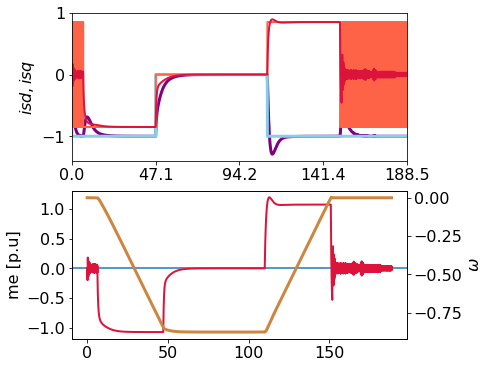

In [31]:
# a = 0.045
Tta, w, me, isd, isq, isdref, isqref = simulateSpeedingUpWithAcceleration()

# print(w)
plotDynamicForSpeedingUp(Tta, w, me, isd, isq, isdref, isqref)

In [32]:
zeroThresh = 0.0005
def calculateIsdIsqRefsBySpeedSimple(w, isSlowingDown):
    isd, isq = 0.0, 0.0
    a = 0.002
    ml = 0.0
    if w < -zeroThresh:
        # a > 0 to slow down, # a < 0 to speed up:
        if(isSlowingDown == 1):
            isd = 0.2
            isq = 0.105
        else:
            isd = 0.5
            isq = -0.09
    else:
        # a < 0 to slow down, # a < 0 to speed up:
        if(isSlowingDown == 1):
            isd = 0.5
            isq = -0.09
        else:
            isd = 0.2
            isq = 0.105
    print("calculate isd, isq:")
    print(isd, isq)
    return isd, isq

w[ii]:
0 0.0 1.2831457301089506e-06
New
Before Braking: w:
1.2831457301089506e-06
0.0
calculate isd, isq:
0.5 -0.09
w[ii]:
1 0.01 3.4487364771790176e-06
New
Before Braking: w:
3.4487364771790176e-06
0.01
calculate isd, isq:
0.5 -0.09
w[ii]:
2 0.02 6.464466396196482e-06
New
Before Braking: w:
6.464466396196482e-06
0.02
calculate isd, isq:
0.5 -0.09
w[ii]:
3 0.03 1.029898711753588e-05
New
Before Braking: w:
1.029898711753588e-05
0.03
calculate isd, isq:
0.5 -0.09
w[ii]:
4 0.04 1.4921921296415881e-05
New
Before Braking: w:
1.4921921296415881e-05
0.04
calculate isd, isq:
0.5 -0.09
w[ii]:
5 0.05 2.0303833041626293e-05
New
Before Braking: w:
2.0303833041626293e-05
0.05
calculate isd, isq:
0.5 -0.09
w[ii]:
6 0.06 2.641619845422877e-05
New
Before Braking: w:
2.641619845422877e-05
0.06
calculate isd, isq:
0.5 -0.09
w[ii]:
7 0.07 3.323137689484074e-05
New
Before Braking: w:
3.323137689484074e-05
0.07
calculate isd, isq:
0.5 -0.09
w[ii]:
8 0.08 4.072258308028152e-05
New
Before Braking: w:
4.07225

0.002833865466111713
2.02
calculate isd, isq:
0.5 -0.09
w[ii]:
203 2.0300000000000002 0.0028394222539914827
New
Before Braking: w:
0.0028394222539914827
2.0300000000000002
calculate isd, isq:
0.5 -0.09
w[ii]:
204 2.04 0.002844878451653667
New
Before Braking: w:
0.002844878451653667
2.04
calculate isd, isq:
0.5 -0.09
w[ii]:
205 2.05 0.002850234501811861
New
Before Braking: w:
0.002850234501811861
2.05
calculate isd, isq:
0.5 -0.09
w[ii]:
206 2.06 0.002855490847485124
New
Before Braking: w:
0.002855490847485124
2.06
calculate isd, isq:
0.5 -0.09
w[ii]:
207 2.07 0.002860647931926478
New
Before Braking: w:
0.002860647931926478
2.07
calculate isd, isq:
0.5 -0.09
w[ii]:
208 2.08 0.00286570619855361
New
Before Braking: w:
0.00286570619855361
2.08
calculate isd, isq:
0.5 -0.09
w[ii]:
209 2.09 0.002870666090881744
New
Before Braking: w:
0.002870666090881744
2.09
calculate isd, isq:
0.5 -0.09
w[ii]:
210 2.1 0.0028755280524585926
New
Before Braking: w:
0.0028755280524585926
2.1
calculate isd, isq

New
Before Braking: w:
0.0009056680214529328
5.68
calculate isd, isq:
0.5 -0.09
w[ii]:
569 5.69 0.0008945789865067028
New
Before Braking: w:
0.0008945789865067028
5.69
calculate isd, isq:
0.5 -0.09
w[ii]:
570 5.7 0.000883474838509288
New
Before Braking: w:
0.000883474838509288
5.7
calculate isd, isq:
0.5 -0.09
w[ii]:
571 5.71 0.0008723556498310783
New
Before Braking: w:
0.0008723556498310783
5.71
calculate isd, isq:
0.5 -0.09
w[ii]:
572 5.72 0.0008612214924145936
New
Before Braking: w:
0.0008612214924145936
5.72
calculate isd, isq:
0.5 -0.09
w[ii]:
573 5.73 0.0008500724377770081
New
Before Braking: w:
0.0008500724377770081
5.73
calculate isd, isq:
0.5 -0.09
w[ii]:
574 5.74 0.0008389085570126515
New
Before Braking: w:
0.0008389085570126515
5.74
calculate isd, isq:
0.5 -0.09
w[ii]:
575 5.75 0.0008277299207955034
New
Before Braking: w:
0.0008277299207955034
5.75
calculate isd, isq:
0.5 -0.09
w[ii]:
576 5.76 0.0008165365993816742
New
Before Braking: w:
0.0008165365993816742
5.76
calculate 

Speeding up from:
8.25
calculate isd, isq:
0.2 0.105
w[ii]:
826 8.26 0.003132669240576015
New
Speeding up from:
8.26
calculate isd, isq:
0.2 0.105
w[ii]:
827 8.27 0.003157287401532453
New
Speeding up from:
8.27
calculate isd, isq:
0.2 0.105
w[ii]:
828 8.28 0.0031819278891786745
New
Speeding up from:
8.28
calculate isd, isq:
0.2 0.105
w[ii]:
829 8.290000000000001 0.0032065901847682697
New
Speeding up from:
8.290000000000001
calculate isd, isq:
0.2 0.105
w[ii]:
830 8.3 0.003231273775521651
New
Speeding up from:
8.3
calculate isd, isq:
0.2 0.105
w[ii]:
831 8.31 0.0032559781545591516
New
Speeding up from:
8.31
calculate isd, isq:
0.2 0.105
w[ii]:
832 8.32 0.003280702820835187
New
Speeding up from:
8.32
calculate isd, isq:
0.2 0.105
w[ii]:
833 8.33 0.0033054472790734514
New
Speeding up from:
8.33
calculate isd, isq:
0.2 0.105
w[ii]:
834 8.34 0.0033302110397031553
New
Speeding up from:
8.34
calculate isd, isq:
0.2 0.105
w[ii]:
835 8.35 0.0033549936187962214
New
Speeding up from:
8.35
calcula

w[ii]:
1014 10.14 0.007802499445621525
New
Speeding up from:
10.14
calculate isd, isq:
0.2 0.105
w[ii]:
1015 10.15 0.007826491265948502
New
Speeding up from:
10.15
calculate isd, isq:
0.2 0.105
w[ii]:
1016 10.16 0.007850468924006043
New
Speeding up from:
10.16
calculate isd, isq:
0.2 0.105
w[ii]:
1017 10.17 0.007874432404533673
New
Speeding up from:
10.17
calculate isd, isq:
0.2 0.105
w[ii]:
1018 10.18 0.007898381693139686
New
Speeding up from:
10.18
calculate isd, isq:
0.2 0.105
w[ii]:
1019 10.19 0.007922316776290933
New
Speeding up from:
10.19
calculate isd, isq:
0.2 0.105
w[ii]:
1020 10.200000000000001 0.007946237641302693
New
Speeding up from:
10.200000000000001
calculate isd, isq:
0.2 0.105
w[ii]:
1021 10.21 0.007970144276328636
New
Speeding up from:
10.21
calculate isd, isq:
0.2 0.105
w[ii]:
1022 10.22 0.007994036670350863
New
Speeding up from:
10.22
calculate isd, isq:
0.2 0.105
w[ii]:
1023 10.23 0.008017914813170032
New
Speeding up from:
10.23
calculate isd, isq:
0.2 0.105
w[ii

calculate isd, isq:
0.2 0.105
w[ii]:
1422 14.22 0.016666425411799794
New
Speeding up from:
14.22
calculate isd, isq:
0.2 0.105
w[ii]:
1423 14.23 0.01668676053253743
New
Speeding up from:
14.23
calculate isd, isq:
0.2 0.105
w[ii]:
1424 14.24 0.01670709264077235
New
Speeding up from:
14.24
calculate isd, isq:
0.2 0.105
w[ii]:
1425 14.25 0.016727421754974683
New
Speeding up from:
14.25
calculate isd, isq:
0.2 0.105
w[ii]:
1426 14.26 0.01674774789352384
New
Speeding up from:
14.26
calculate isd, isq:
0.2 0.105
w[ii]:
1427 14.27 0.016768071074708794
New
Speeding up from:
14.27
calculate isd, isq:
0.2 0.105
w[ii]:
1428 14.280000000000001 0.01678839131672835
New
Speeding up from:
14.280000000000001
calculate isd, isq:
0.2 0.105
w[ii]:
1429 14.290000000000001 0.016808708637691395
New
Speeding up from:
14.290000000000001
calculate isd, isq:
0.2 0.105
w[ii]:
1430 14.3 0.016829023055617138
New
Speeding up from:
14.3
calculate isd, isq:
0.2 0.105
w[ii]:
1431 14.31 0.01684933458843541
New
Speeding 

Speeding up from:
18.36
calculate isd, isq:
0.2 0.105
w[ii]:
1837 18.37 0.024981560186200114
New
Speeding up from:
18.37
calculate isd, isq:
0.2 0.105
w[ii]:
1838 18.38 0.02500148027628904
New
Speeding up from:
18.38
calculate isd, isq:
0.2 0.105
w[ii]:
1839 18.39 0.025021400235671586
New
Speeding up from:
18.39
calculate isd, isq:
0.2 0.105
w[ii]:
1840 18.400000000000002 0.025041320065464827
New
Speeding up from:
18.400000000000002
calculate isd, isq:
0.2 0.105
w[ii]:
1841 18.41 0.025061239766776156
New
Speeding up from:
18.41
calculate isd, isq:
0.2 0.105
w[ii]:
1842 18.42 0.02508115934070335
New
Speeding up from:
18.42
calculate isd, isq:
0.2 0.105
w[ii]:
1843 18.43 0.025101078788334633
New
Speeding up from:
18.43
calculate isd, isq:
0.2 0.105
w[ii]:
1844 18.44 0.02512099811074875
New
Speeding up from:
18.44
calculate isd, isq:
0.2 0.105
w[ii]:
1845 18.45 0.02514091730901504
New
Speeding up from:
18.45
calculate isd, isq:
0.2 0.105
w[ii]:
1846 18.46 0.02516083638419351
New
Speeding 

w[ii]:
2125 21.25 0.03071569651075575
New
Speeding up from:
21.25
calculate isd, isq:
0.2 0.105
w[ii]:
2126 21.26 0.0307356014775555
New
Speeding up from:
21.26
calculate isd, isq:
0.2 0.105
w[ii]:
2127 21.27 0.030755506423046163
New
Speeding up from:
21.27
calculate isd, isq:
0.2 0.105
w[ii]:
2128 21.28 0.030775411347278053
New
Speeding up from:
21.28
calculate isd, isq:
0.2 0.105
w[ii]:
2129 21.29 0.030795316250300856
New
Speeding up from:
21.29
calculate isd, isq:
0.2 0.105
w[ii]:
2130 21.3 0.0308152211321636
New
Speeding up from:
21.3
calculate isd, isq:
0.2 0.105
w[ii]:
2131 21.31 0.030835125992914693
New
Speeding up from:
21.31
calculate isd, isq:
0.2 0.105
w[ii]:
2132 21.32 0.03085503083260192
New
Speeding up from:
21.32
calculate isd, isq:
0.2 0.105
w[ii]:
2133 21.330000000000002 0.030874935651272445
New
Speeding up from:
21.330000000000002
calculate isd, isq:
0.2 0.105
w[ii]:
2134 21.34 0.030894840448972838
New
Speeding up from:
21.34
calculate isd, isq:
0.2 0.105
w[ii]:
2135 

2352 23.52 0.03523363280026341
New
Speeding up from:
23.52
calculate isd, isq:
0.2 0.105
w[ii]:
2353 23.53 0.0352535335718434
New
Speeding up from:
23.53
calculate isd, isq:
0.2 0.105
w[ii]:
2354 23.54 0.035273434326614714
New
Speeding up from:
23.54
calculate isd, isq:
0.2 0.105
w[ii]:
2355 23.55 0.035293335064590606
New
Speeding up from:
23.55
calculate isd, isq:
0.2 0.105
w[ii]:
2356 23.56 0.03531323578578441
New
Speeding up from:
23.56
calculate isd, isq:
0.2 0.105
w[ii]:
2357 23.57 0.035333136490209485
New
Speeding up from:
23.57
calculate isd, isq:
0.2 0.105
w[ii]:
2358 23.580000000000002 0.035353037177879215
New
Speeding up from:
23.580000000000002
calculate isd, isq:
0.2 0.105
w[ii]:
2359 23.59 0.03537293784880705
New
Speeding up from:
23.59
calculate isd, isq:
0.2 0.105
w[ii]:
2360 23.6 0.03539283850300648
New
Speeding up from:
23.6
calculate isd, isq:
0.2 0.105
w[ii]:
2361 23.61 0.03541273914049102
New
Speeding up from:
23.61
calculate isd, isq:
0.2 0.105
w[ii]:
2362 23.62 0.

2604 26.04 0.04024815363560148
New
Speeding up from:
26.04
calculate isd, isq:
0.2 0.105
w[ii]:
2605 26.05 0.04026805069153928
New
Speeding up from:
26.05
calculate isd, isq:
0.2 0.105
w[ii]:
2606 26.060000000000002 0.04028794773485395
New
Speeding up from:
26.060000000000002
calculate isd, isq:
0.2 0.105
w[ii]:
2607 26.07 0.0403078447655809
New
Speeding up from:
26.07
calculate isd, isq:
0.2 0.105
w[ii]:
2608 26.080000000000002 0.04032774178375513
New
Speeding up from:
26.080000000000002
calculate isd, isq:
0.2 0.105
w[ii]:
2609 26.09 0.04034763878941124
New
Speeding up from:
26.09
calculate isd, isq:
0.2 0.105
w[ii]:
2610 26.1 0.040367535782583466
New
Speeding up from:
26.1
calculate isd, isq:
0.2 0.105
w[ii]:
2611 26.11 0.040387432763305656
New
Speeding up from:
26.11
calculate isd, isq:
0.2 0.105
w[ii]:
2612 26.12 0.040407329731611305
New
Speeding up from:
26.12
calculate isd, isq:
0.2 0.105
w[ii]:
2613 26.13 0.040427226687533555
New
Speeding up from:
26.13
calculate isd, isq:
0.2 

3086 30.86 0.04983747748891652
New
Speeding up from:
30.86
calculate isd, isq:
0.2 0.105
w[ii]:
3087 30.87 0.04985737080525518
New
Speeding up from:
30.87
calculate isd, isq:
0.2 0.105
w[ii]:
3088 30.88 0.04987726411736951
New
Speeding up from:
30.88
calculate isd, isq:
0.2 0.105
w[ii]:
3089 30.89 0.04989715742526988
New
Speeding up from:
30.89
calculate isd, isq:
0.2 0.105
w[ii]:
3090 30.900000000000002 0.049917050728966635
New
Speeding up from:
30.900000000000002
calculate isd, isq:
0.2 0.105
w[ii]:
3091 30.91 0.04993694402847011
New
Speeding up from:
30.91
calculate isd, isq:
0.2 0.105
w[ii]:
3092 30.92 0.04995683732379062
New
Speeding up from:
30.92
calculate isd, isq:
0.2 0.105
w[ii]:
3093 30.93 0.04997673061493845
New
Speeding up from:
30.93
calculate isd, isq:
0.2 0.105
w[ii]:
3094 30.94 0.04999662390192386
New
Speeding up from:
30.94
calculate isd, isq:
0.2 0.105
w[ii]:
3095 30.95 0.05001651718475707
New
Speeding up from:
30.95
calculate isd, isq:
0.2 0.105
w[ii]:
3096 30.96 0.

3426 34.26 0.056601017485903016
New
Speeding up from:
34.26
calculate isd, isq:
0.2 0.105
w[ii]:
3427 34.27 0.05662090983186941
New
Speeding up from:
34.27
calculate isd, isq:
0.2 0.105
w[ii]:
3428 34.28 0.056640802176028536
New
Speeding up from:
34.28
calculate isd, isq:
0.2 0.105
w[ii]:
3429 34.29 0.05666069451838494
New
Speeding up from:
34.29
calculate isd, isq:
0.2 0.105
w[ii]:
3430 34.300000000000004 0.0566805868589431
New
Speeding up from:
34.300000000000004
calculate isd, isq:
0.2 0.105
w[ii]:
3431 34.31 0.05670047919770756
New
Speeding up from:
34.31
calculate isd, isq:
0.2 0.105
w[ii]:
3432 34.32 0.056720371534682776
New
Speeding up from:
34.32
calculate isd, isq:
0.2 0.105
w[ii]:
3433 34.33 0.056740263869873256
New
Speeding up from:
34.33
calculate isd, isq:
0.2 0.105
w[ii]:
3434 34.34 0.056760156203283466
New
Speeding up from:
34.34
calculate isd, isq:
0.2 0.105
w[ii]:
3435 34.35 0.056780048534917846
New
Speeding up from:
34.35
calculate isd, isq:
0.2 0.105
w[ii]:
3436 34.3

0.2 0.105
w[ii]:
3854 38.54 0.06511481758449515
New
Speeding up from:
38.54
calculate isd, isq:
0.2 0.105
w[ii]:
3855 38.550000000000004 0.06513470944716795
New
Speeding up from:
38.550000000000004
calculate isd, isq:
0.2 0.105
w[ii]:
3856 38.56 0.06515460130929199
New
Speeding up from:
38.56
calculate isd, isq:
0.2 0.105
w[ii]:
3857 38.57 0.06517449317086829
New
Speeding up from:
38.57
calculate isd, isq:
0.2 0.105
w[ii]:
3858 38.58 0.06519438503189791
New
Speeding up from:
38.58
calculate isd, isq:
0.2 0.105
w[ii]:
3859 38.59 0.06521427689238192
New
Speeding up from:
38.59
calculate isd, isq:
0.2 0.105
w[ii]:
3860 38.6 0.06523416875232138
New
Speeding up from:
38.6
calculate isd, isq:
0.2 0.105
w[ii]:
3861 38.61 0.06525406061171735
New
Speeding up from:
38.61
calculate isd, isq:
0.2 0.105
w[ii]:
3862 38.62 0.06527395247057088
New
Speeding up from:
38.62
calculate isd, isq:
0.2 0.105
w[ii]:
3863 38.63 0.06529384432888301
New
Speeding up from:
38.63
calculate isd, isq:
0.2 0.105
w[ii]:

40.69
calculate isd, isq:
0.2 0.105
w[ii]:
4070 40.7 0.06941144887083775
New
Speeding up from:
40.7
calculate isd, isq:
0.2 0.105
w[ii]:
4071 40.71 0.06943134063822147
New
Speeding up from:
40.71
calculate isd, isq:
0.2 0.105
w[ii]:
4072 40.72 0.0694512324052628
New
Speeding up from:
40.72
calculate isd, isq:
0.2 0.105
w[ii]:
4073 40.730000000000004 0.06947112417196254
New
Speeding up from:
40.730000000000004
calculate isd, isq:
0.2 0.105
w[ii]:
4074 40.74 0.0694910159383215
New
Speeding up from:
40.74
calculate isd, isq:
0.2 0.105
w[ii]:
4075 40.75 0.06951090770434044
New
Speeding up from:
40.75
calculate isd, isq:
0.2 0.105
w[ii]:
4076 40.76 0.06953079947002021
New
Speeding up from:
40.76
calculate isd, isq:
0.2 0.105
w[ii]:
4077 40.77 0.06955069123536155
New
Speeding up from:
40.77
calculate isd, isq:
0.2 0.105
w[ii]:
4078 40.78 0.06957058300036528
New
Speeding up from:
40.78
calculate isd, isq:
0.2 0.105
w[ii]:
4079 40.79 0.06959047476503215
New
Speeding up from:
40.79
calculate is

w[ii]:
4434 44.34 0.07665203484789154
New
Speeding up from:
44.34
calculate isd, isq:
0.2 0.105
w[ii]:
4435 44.35 0.07667192653157459
New
Speeding up from:
44.35
calculate isd, isq:
0.2 0.105
w[ii]:
4436 44.36 0.07669181821511259
New
Speeding up from:
44.36
calculate isd, isq:
0.2 0.105
w[ii]:
4437 44.37 0.07671170989850586
New
Speeding up from:
44.37
calculate isd, isq:
0.2 0.105
w[ii]:
4438 44.38 0.07673160158175471
New
Speeding up from:
44.38
calculate isd, isq:
0.2 0.105
w[ii]:
4439 44.39 0.07675149326485953
New
Speeding up from:
44.39
calculate isd, isq:
0.2 0.105
w[ii]:
4440 44.4 0.07677138494782063
New
Speeding up from:
44.4
calculate isd, isq:
0.2 0.105
w[ii]:
4441 44.410000000000004 0.07679127663063832
New
Speeding up from:
44.410000000000004
calculate isd, isq:
0.2 0.105
w[ii]:
4442 44.42 0.07681116831331297
New
Speeding up from:
44.42
calculate isd, isq:
0.2 0.105
w[ii]:
4443 44.43 0.0768310599958449
New
Speeding up from:
44.43
calculate isd, isq:
0.2 0.105
w[ii]:
4444 44.44

4897 48.97 0.08374449397184161
New
Uniform speed from:
48.97
w[ii]:
4898 48.980000000000004 0.08374998530255029
New
Uniform speed from:
48.980000000000004
w[ii]:
4899 48.99 0.08375546858898286
New
Uniform speed from:
48.99
w[ii]:
4900 49.0 0.08376094385001857
New
Uniform speed from:
49.0
w[ii]:
4901 49.01 0.08376641110317874
New
Uniform speed from:
49.01
w[ii]:
4902 49.02 0.08377187036467512
New
Uniform speed from:
49.02
w[ii]:
4903 49.03 0.08377732164945664
New
Uniform speed from:
49.03
w[ii]:
4904 49.04 0.08378276497125495
New
Uniform speed from:
49.04
w[ii]:
4905 49.050000000000004 0.08378820034262856
New
Uniform speed from:
49.050000000000004
w[ii]:
4906 49.06 0.08379362777500574
New
Uniform speed from:
49.06
w[ii]:
4907 49.07 0.08379904727872628
New
Uniform speed from:
49.07
w[ii]:
4908 49.08 0.08380445886308187
New
Uniform speed from:
49.08
w[ii]:
4909 49.09 0.08380986253635545
New
Uniform speed from:
49.09
w[ii]:
4910 49.1 0.08381525830585937
New
Uniform speed from:
49.1
w[ii]:


w[ii]:
5421 54.21 0.08553694237888874
New
Uniform speed from:
54.21
w[ii]:
5422 54.22 0.0855386458669856
New
Uniform speed from:
54.22
w[ii]:
5423 54.230000000000004 0.08554034493472999
New
Uniform speed from:
54.230000000000004
w[ii]:
5424 54.24 0.08554203959351664
New
Uniform speed from:
54.24
w[ii]:
5425 54.25 0.08554372985471675
New
Uniform speed from:
54.25
w[ii]:
5426 54.26 0.08554541572967797
New
Uniform speed from:
54.26
w[ii]:
5427 54.27 0.08554709722972437
New
Uniform speed from:
54.27
w[ii]:
5428 54.28 0.08554877436615643
New
Uniform speed from:
54.28
w[ii]:
5429 54.29 0.08555044715025098
New
Uniform speed from:
54.29
w[ii]:
5430 54.300000000000004 0.08555211559326122
New
Uniform speed from:
54.300000000000004
w[ii]:
5431 54.31 0.0855537797064167
New
Uniform speed from:
54.31
w[ii]:
5432 54.32 0.08555543950092326
New
Uniform speed from:
54.32
w[ii]:
5433 54.33 0.0855570949879631
New
Uniform speed from:
54.33
w[ii]:
5434 54.34 0.08555874617869465
New
Uniform speed from:
54.34

w[ii]:
5960 59.6 0.08603425993013292
New
Uniform speed from:
59.6
w[ii]:
5961 59.61 0.0860346917498039
New
Uniform speed from:
59.61
w[ii]:
5962 59.620000000000005 0.08603512249682824
New
Uniform speed from:
59.620000000000005
w[ii]:
5963 59.63 0.0860355521739314
New
Uniform speed from:
59.63
w[ii]:
5964 59.64 0.08603598078383148
New
Uniform speed from:
59.64
w[ii]:
5965 59.65 0.08603640832923938
New
Uniform speed from:
59.65
w[ii]:
5966 59.660000000000004 0.08603683481285865
New
Uniform speed from:
59.660000000000004
w[ii]:
5967 59.67 0.08603726023738562
New
Uniform speed from:
59.67
w[ii]:
5968 59.68 0.08603768460550935
New
Uniform speed from:
59.68
w[ii]:
5969 59.69 0.08603810791991175
New
Uniform speed from:
59.69
w[ii]:
5970 59.7 0.08603853018326747
New
Uniform speed from:
59.7
w[ii]:
5971 59.71 0.08603895139824404
New
Uniform speed from:
59.71
w[ii]:
5972 59.72 0.08603937156750184
New
Uniform speed from:
59.72
w[ii]:
5973 59.730000000000004 0.0860397906936941
New
Uniform speed fr

w[ii]:
6254 62.54 0.08612453812643472
New
Uniform speed from:
62.54
w[ii]:
6255 62.550000000000004 0.08612474681546067
New
Uniform speed from:
62.550000000000004
w[ii]:
6256 62.56 0.08612495499063492
New
Uniform speed from:
62.56
w[ii]:
6257 62.57 0.08612516265322763
New
Uniform speed from:
62.57
w[ii]:
6258 62.58 0.08612536980450579
New
Uniform speed from:
62.58
w[ii]:
6259 62.59 0.08612557644573314
New
Uniform speed from:
62.59
w[ii]:
6260 62.6 0.08612578257817026
New
Uniform speed from:
62.6
w[ii]:
6261 62.61 0.0861259882030746
New
Uniform speed from:
62.61
w[ii]:
6262 62.620000000000005 0.08612619332170042
New
Uniform speed from:
62.620000000000005
w[ii]:
6263 62.63 0.08612639793529878
New
Uniform speed from:
62.63
w[ii]:
6264 62.64 0.08612660204511767
New
Uniform speed from:
62.64
w[ii]:
6265 62.65 0.08612680565240186
New
Uniform speed from:
62.65
w[ii]:
6266 62.660000000000004 0.08612700875839308
New
Uniform speed from:
62.660000000000004
w[ii]:
6267 62.67 0.08612721136432987
New

6816 68.16 0.08618810112749048
New
Uniform speed from:
68.16
w[ii]:
6817 68.17 0.08618815335843455
New
Uniform speed from:
68.17
w[ii]:
6818 68.18 0.08618820546071415
New
Uniform speed from:
68.18
w[ii]:
6819 68.19 0.0861882574346459
New
Uniform speed from:
68.19
w[ii]:
6820 68.2 0.08618830928054563
New
Uniform speed from:
68.2
w[ii]:
6821 68.21000000000001 0.08618836099872842
New
Uniform speed from:
68.21000000000001
w[ii]:
6822 68.22 0.08618841258950853
New
Uniform speed from:
68.22
w[ii]:
6823 68.23 0.08618846405319948
New
Uniform speed from:
68.23
w[ii]:
6824 68.24 0.08618851539011402
New
Uniform speed from:
68.24
w[ii]:
6825 68.25 0.08618856660056409
New
Uniform speed from:
68.25
w[ii]:
6826 68.26 0.08618861768486095
New
Uniform speed from:
68.26
w[ii]:
6827 68.27 0.086188668643315
New
Uniform speed from:
68.27
w[ii]:
6828 68.28 0.08618871947623594
New
Uniform speed from:
68.28
w[ii]:
6829 68.29 0.0861887701839327
New
Uniform speed from:
68.29
w[ii]:
6830 68.3 0.08618882076671341


New
Uniform speed from:
71.41
w[ii]:
7142 71.42 0.0861998146497586
New
Uniform speed from:
71.42
w[ii]:
7143 71.43 0.08619983801782634
New
Uniform speed from:
71.43
w[ii]:
7144 71.44 0.08619986132829947
New
Uniform speed from:
71.44
w[ii]:
7145 71.45 0.08619988458131994
New
Uniform speed from:
71.45
w[ii]:
7146 71.46000000000001 0.08619990777702928
New
Uniform speed from:
71.46000000000001
w[ii]:
7147 71.47 0.08619993091556873
New
Uniform speed from:
71.47
w[ii]:
7148 71.48 0.08619995399707912
New
Uniform speed from:
71.48
w[ii]:
7149 71.49 0.08619997702170099
New
Uniform speed from:
71.49
w[ii]:
7150 71.5 0.08619999998957449
New
Uniform speed from:
71.5
w[ii]:
7151 71.51 0.08620002290083946
New
Uniform speed from:
71.51
w[ii]:
7152 71.52 0.08620004575563536
New
Uniform speed from:
71.52
w[ii]:
7153 71.53 0.08620006855410138
New
Uniform speed from:
71.53
w[ii]:
7154 71.54 0.08620009129637628
New
Uniform speed from:
71.54
w[ii]:
7155 71.55 0.08620011398259851
New
Uniform speed from:
71.

w[ii]:
7685 76.85000000000001 0.08620681294024181
New
Uniform speed from:
76.85000000000001
w[ii]:
7686 76.86 0.08620681905860472
New
Uniform speed from:
76.86
w[ii]:
7687 76.87 0.08620682516188645
New
Uniform speed from:
76.87
w[ii]:
7688 76.88 0.08620683125012414
New
Uniform speed from:
76.88
w[ii]:
7689 76.89 0.08620683732335488
New
Uniform speed from:
76.89
w[ii]:
7690 76.9 0.08620684338161565
New
Uniform speed from:
76.9
w[ii]:
7691 76.91 0.08620684942494337
New
Uniform speed from:
76.91
w[ii]:
7692 76.92 0.08620685545337486
New
Uniform speed from:
76.92
w[ii]:
7693 76.93 0.08620686146694682
New
Uniform speed from:
76.93
w[ii]:
7694 76.94 0.08620686746569586
New
Uniform speed from:
76.94
w[ii]:
7695 76.95 0.08620687344965854
New
Uniform speed from:
76.95
w[ii]:
7696 76.96000000000001 0.0862068794188713
New
Uniform speed from:
76.96000000000001
w[ii]:
7697 76.97 0.08620688537337053
New
Uniform speed from:
76.97
w[ii]:
7698 76.98 0.08620689131319244
New
Uniform speed from:
76.98
w[i

New
Uniform speed from:
79.76
w[ii]:
7977 79.77 0.08620808769347656
New
Uniform speed from:
79.77
w[ii]:
7978 79.78 0.08620809066970399
New
Uniform speed from:
79.78
w[ii]:
7979 79.79 0.08620809363859534
New
Uniform speed from:
79.79
w[ii]:
7980 79.8 0.08620809660016873
New
Uniform speed from:
79.8
w[ii]:
7981 79.81 0.0862080995544422
New
Uniform speed from:
79.81
w[ii]:
7982 79.82000000000001 0.08620810250143372
New
Uniform speed from:
79.82000000000001
w[ii]:
7983 79.83 0.08620810544116125
New
Uniform speed from:
79.83
w[ii]:
7984 79.84 0.0862081083736427
New
Uniform speed from:
79.84
w[ii]:
7985 79.85000000000001 0.08620811129889593
New
Uniform speed from:
79.85000000000001
w[ii]:
7986 79.86 0.08620811421693873
New
Uniform speed from:
79.86
w[ii]:
7987 79.87 0.08620811712778889
New
Uniform speed from:
79.87
w[ii]:
7988 79.88 0.08620812003146414
New
Uniform speed from:
79.88
w[ii]:
7989 79.89 0.08620812292798216
New
Uniform speed from:
79.89
w[ii]:
7990 79.9 0.08620812581736059
New
U

w[ii]:
8264 82.64 0.08620870049561724
New
Uniform speed from:
82.64
w[ii]:
8265 82.65 0.08620870196136145
New
Uniform speed from:
82.65
w[ii]:
8266 82.66 0.0862087034234928
New
Uniform speed from:
82.66
w[ii]:
8267 82.67 0.08620870488202018
New
Uniform speed from:
82.67
w[ii]:
8268 82.68 0.08620870633695249
New
Uniform speed from:
82.68
w[ii]:
8269 82.69 0.08620870778829857
New
Uniform speed from:
82.69
w[ii]:
8270 82.7 0.08620870923606726
New
Uniform speed from:
82.7
w[ii]:
8271 82.71000000000001 0.08620871068026739
New
Uniform speed from:
82.71000000000001
w[ii]:
8272 82.72 0.08620871212090774
New
Uniform speed from:
82.72
w[ii]:
8273 82.73 0.0862087135579971
New
Uniform speed from:
82.73
w[ii]:
8274 82.74 0.0862087149915442
New
Uniform speed from:
82.74
w[ii]:
8275 82.75 0.0862087164215578
New
Uniform speed from:
82.75
w[ii]:
8276 82.76 0.08620871784804661
New
Uniform speed from:
82.76
w[ii]:
8277 82.77 0.08620871927101931
New
Uniform speed from:
82.77
w[ii]:
8278 82.78 0.0862087206

8769 87.69 0.08620912414609029
New
Uniform speed from:
87.69
w[ii]:
8770 87.7 0.08620912456759261
New
Uniform speed from:
87.7
w[ii]:
8771 87.71000000000001 0.08620912498805598
New
Uniform speed from:
87.71000000000001
w[ii]:
8772 87.72 0.08620912540748298
New
Uniform speed from:
87.72
w[ii]:
8773 87.73 0.08620912582587613
New
Uniform speed from:
87.73
w[ii]:
8774 87.74 0.08620912624323801
New
Uniform speed from:
87.74
w[ii]:
8775 87.75 0.08620912665957116
New
Uniform speed from:
87.75
w[ii]:
8776 87.76 0.08620912707487811
New
Uniform speed from:
87.76
w[ii]:
8777 87.77 0.08620912748916139
New
Uniform speed from:
87.77
w[ii]:
8778 87.78 0.08620912790242351
New
Uniform speed from:
87.78
w[ii]:
8779 87.79 0.08620912831466701
New
Uniform speed from:
87.79
w[ii]:
8780 87.8 0.08620912872589441
New
Uniform speed from:
87.8
w[ii]:
8781 87.81 0.08620912913610819
New
Uniform speed from:
87.81
w[ii]:
8782 87.82000000000001 0.08620912954531085
New
Uniform speed from:
87.82000000000001
w[ii]:
8783

9086 90.86 0.08620921694341685
New
Uniform speed from:
90.86
w[ii]:
9087 90.87 0.08620921713618876
New
Uniform speed from:
90.87
w[ii]:
9088 90.88 0.0862092173284855
New
Uniform speed from:
90.88
w[ii]:
9089 90.89 0.08620921752030826
New
Uniform speed from:
90.89
w[ii]:
9090 90.9 0.08620921771165824
New
Uniform speed from:
90.9
w[ii]:
9091 90.91 0.08620921790253656
New
Uniform speed from:
90.91
w[ii]:
9092 90.92 0.0862092180929444
New
Uniform speed from:
90.92
w[ii]:
9093 90.93 0.08620921828288294
New
Uniform speed from:
90.93
w[ii]:
9094 90.94 0.08620921847235331
New
Uniform speed from:
90.94
w[ii]:
9095 90.95 0.08620921866135668
New
Uniform speed from:
90.95
w[ii]:
9096 90.96000000000001 0.08620921884989419
New
Uniform speed from:
90.96000000000001
w[ii]:
9097 90.97 0.086209219037967
New
Uniform speed from:
90.97
w[ii]:
9098 90.98 0.08620921922557624
New
Uniform speed from:
90.98
w[ii]:
9099 90.99 0.08620921941272305
New
Uniform speed from:
90.99
w[ii]:
9100 91.0 0.08620921959940858


9565 95.65 0.08620927117171619
New
Uniform speed from:
95.65
w[ii]:
9566 95.66 0.08620927123082764
New
Uniform speed from:
95.66
w[ii]:
9567 95.67 0.0862092712897934
New
Uniform speed from:
95.67
w[ii]:
9568 95.68 0.08620927134861382
New
Uniform speed from:
95.68
w[ii]:
9569 95.69 0.08620927140728926
New
Uniform speed from:
95.69
w[ii]:
9570 95.7 0.08620927146582008
New
Uniform speed from:
95.7
w[ii]:
9571 95.71000000000001 0.08620927152420664
New
Uniform speed from:
95.71000000000001
w[ii]:
9572 95.72 0.08620927158244927
New
Uniform speed from:
95.72
w[ii]:
9573 95.73 0.08620927164054837
New
Uniform speed from:
95.73
w[ii]:
9574 95.74000000000001 0.08620927169850427
New
Uniform speed from:
95.74000000000001
w[ii]:
9575 95.75 0.0862092717563173
New
Uniform speed from:
95.75
w[ii]:
9576 95.76 0.08620927181398787
New
Uniform speed from:
95.76
w[ii]:
9577 95.77 0.08620927187151628
New
Uniform speed from:
95.77
w[ii]:
9578 95.78 0.0862092719289029
New
Uniform speed from:
95.78
w[ii]:
9579 

w[ii]:
10183 101.83 0.08620928993576005
New
Uniform speed from:
101.83
w[ii]:
10184 101.84 0.08620928994862266
New
Uniform speed from:
101.84
w[ii]:
10185 101.85000000000001 0.08620928996145355
New
Uniform speed from:
101.85000000000001
w[ii]:
10186 101.86 0.08620928997425281
New
Uniform speed from:
101.86
w[ii]:
10187 101.87 0.08620928998702053
New
Uniform speed from:
101.87
w[ii]:
10188 101.88 0.0862092899997568
New
Uniform speed from:
101.88
w[ii]:
10189 101.89 0.08620929001246165
New
Uniform speed from:
101.89
w[ii]:
10190 101.9 0.08620929002513521
New
Uniform speed from:
101.9
w[ii]:
10191 101.91 0.08620929003777753
New
Uniform speed from:
101.91
w[ii]:
10192 101.92 0.08620929005038869
New
Uniform speed from:
101.92
w[ii]:
10193 101.93 0.08620929006296876
New
Uniform speed from:
101.93
w[ii]:
10194 101.94 0.08620929007551782
New
Uniform speed from:
101.94
w[ii]:
10195 101.95 0.08620929008803596
New
Uniform speed from:
101.95
w[ii]:
10196 101.96000000000001 0.08620929010052324
New


10434 104.34 0.0862092923454117
New
Uniform speed from:
104.34
w[ii]:
10435 104.35000000000001 0.0862092923523351
New
Uniform speed from:
104.35000000000001
w[ii]:
10436 104.36 0.08620929235924142
New
Uniform speed from:
104.36
w[ii]:
10437 104.37 0.08620929236613073
New
Uniform speed from:
104.37
w[ii]:
10438 104.38 0.08620929237300307
New
Uniform speed from:
104.38
w[ii]:
10439 104.39 0.08620929237985846
New
Uniform speed from:
104.39
w[ii]:
10440 104.4 0.08620929238669696
New
Uniform speed from:
104.4
w[ii]:
10441 104.41 0.0862092923935186
New
Uniform speed from:
104.41
w[ii]:
10442 104.42 0.08620929240032343
New
Uniform speed from:
104.42
w[ii]:
10443 104.43 0.0862092924071115
New
Uniform speed from:
104.43
w[ii]:
10444 104.44 0.08620929241388284
New
Uniform speed from:
104.44
w[ii]:
10445 104.45 0.08620929242063749
New
Uniform speed from:
104.45
w[ii]:
10446 104.46000000000001 0.08620929242737549
New
Uniform speed from:
104.46000000000001
w[ii]:
10447 104.47 0.08620929243409686
Ne

calculate isd, isq:
0.5 -0.09
w[ii]:
10999 109.99000000000001 0.08620714809713004
New
Before Braking: w:
0.08620714809713004
109.99000000000001
calculate isd, isq:
0.5 -0.09
w[ii]:
11000 110.0 0.08620573579874026
New
Before Braking: w:
0.08620573579874026
110.0
calculate isd, isq:
0.5 -0.09
w[ii]:
11001 110.01 0.08620398412151767
New
Before Braking: w:
0.08620398412151767
110.01
calculate isd, isq:
0.5 -0.09
w[ii]:
11002 110.02 0.08620189834437308
New
Before Braking: w:
0.08620189834437308
110.02
calculate isd, isq:
0.5 -0.09
w[ii]:
11003 110.03 0.08619948365091958
New
Before Braking: w:
0.08619948365091958
110.03
calculate isd, isq:
0.5 -0.09
w[ii]:
11004 110.04 0.08619674513163761
New
Before Braking: w:
0.08619674513163761
110.04
calculate isd, isq:
0.5 -0.09
w[ii]:
11005 110.05 0.08619368778597006
New
Before Braking: w:
0.08619368778597006
110.05
calculate isd, isq:
0.5 -0.09
w[ii]:
11006 110.06 0.08619031652435472
New
Before Braking: w:
0.08619031652435472
110.06
calculate isd, isq

11336 113.36 0.07976716030240417
New
Before Braking: w:
0.07976716030240417
113.36
calculate isd, isq:
0.5 -0.09
w[ii]:
11337 113.37 0.07974550662281502
New
Before Braking: w:
0.07974550662281502
113.37
calculate isd, isq:
0.5 -0.09
w[ii]:
11338 113.38 0.07972386811568642
New
Before Braking: w:
0.07972386811568642
113.38
calculate isd, isq:
0.5 -0.09
w[ii]:
11339 113.39 0.07970224482214863
New
Before Braking: w:
0.07970224482214863
113.39
calculate isd, isq:
0.5 -0.09
w[ii]:
11340 113.4 0.07968063678226593
New
Before Braking: w:
0.07968063678226593
113.4
calculate isd, isq:
0.5 -0.09
w[ii]:
11341 113.41 0.07965904403504764
New
Before Braking: w:
0.07965904403504764
113.41
calculate isd, isq:
0.5 -0.09
w[ii]:
11342 113.42 0.07963746661845904
New
Before Braking: w:
0.07963746661845904
113.42
calculate isd, isq:
0.5 -0.09
w[ii]:
11343 113.43 0.07961590456943213
New
Before Braking: w:
0.07961590456943213
113.43
calculate isd, isq:
0.5 -0.09
w[ii]:
11344 113.44 0.07959435792387638
New
Befor

calculate isd, isq:
0.5 -0.09
w[ii]:
11594 115.94 0.07468087190081364
New
Before Braking: w:
0.07468087190081364
115.94
calculate isd, isq:
0.5 -0.09
w[ii]:
11595 115.95 0.07466283845556489
New
Before Braking: w:
0.07466283845556489
115.95
calculate isd, isq:
0.5 -0.09
w[ii]:
11596 115.96000000000001 0.07464481494152117
New
Before Braking: w:
0.07464481494152117
115.96000000000001
calculate isd, isq:
0.5 -0.09
w[ii]:
11597 115.97 0.0746268013217034
New
Before Braking: w:
0.0746268013217034
115.97
calculate isd, isq:
0.5 -0.09
w[ii]:
11598 115.98 0.07460879755918891
New
Before Braking: w:
0.07460879755918891
115.98
calculate isd, isq:
0.5 -0.09
w[ii]:
11599 115.99000000000001 0.0745908036171123
New
Before Braking: w:
0.0745908036171123
115.99000000000001
calculate isd, isq:
0.5 -0.09
w[ii]:
11600 116.0 0.07457281945866641
New
Before Braking: w:
0.07457281945866641
116.0
calculate isd, isq:
0.5 -0.09
w[ii]:
11601 116.01 0.07455484504710294
New
Before Braking: w:
0.07455484504710294
116.0

w[ii]:
11870 118.7 0.0699714699641215
New
Before Braking: w:
0.0699714699641215
118.7
calculate isd, isq:
0.5 -0.09
w[ii]:
11871 118.71000000000001 0.06995506181131297
New
Before Braking: w:
0.06995506181131297
118.71000000000001
calculate isd, isq:
0.5 -0.09
w[ii]:
11872 118.72 0.0699386566021534
New
Before Braking: w:
0.0699386566021534
118.72
calculate isd, isq:
0.5 -0.09
w[ii]:
11873 118.73 0.0699222543228636
New
Before Braking: w:
0.0699222543228636
118.73
calculate isd, isq:
0.5 -0.09
w[ii]:
11874 118.74000000000001 0.06990585495973059
New
Before Braking: w:
0.06990585495973059
118.74000000000001
calculate isd, isq:
0.5 -0.09
w[ii]:
11875 118.75 0.06988945849910709
New
Before Braking: w:
0.06988945849910709
118.75
calculate isd, isq:
0.5 -0.09
w[ii]:
11876 118.76 0.0698730649274115
New
Before Braking: w:
0.0698730649274115
118.76
calculate isd, isq:
0.5 -0.09
w[ii]:
11877 118.77 0.06985667423112749
New
Before Braking: w:
0.06985667423112749
118.77
calculate isd, isq:
0.5 -0.09
w[

0.06415128206273389
122.32000000000001
calculate isd, isq:
0.5 -0.09
w[ii]:
12233 122.33 0.06413540507877805
New
Before Braking: w:
0.06413540507877805
122.33
calculate isd, isq:
0.5 -0.09
w[ii]:
12234 122.34 0.06411952875348124
New
Before Braking: w:
0.06411952875348124
122.34
calculate isd, isq:
0.5 -0.09
w[ii]:
12235 122.35000000000001 0.06410365308467339
New
Before Braking: w:
0.06410365308467339
122.35000000000001
calculate isd, isq:
0.5 -0.09
w[ii]:
12236 122.36 0.0640877780701947
New
Before Braking: w:
0.0640877780701947
122.36
calculate isd, isq:
0.5 -0.09
w[ii]:
12237 122.37 0.06407190370789564
New
Before Braking: w:
0.06407190370789564
122.37
calculate isd, isq:
0.5 -0.09
w[ii]:
12238 122.38 0.06405602999563688
New
Before Braking: w:
0.06405602999563688
122.38
calculate isd, isq:
0.5 -0.09
w[ii]:
12239 122.39 0.06404015693128917
New
Before Braking: w:
0.06404015693128917
122.39
calculate isd, isq:
0.5 -0.09
w[ii]:
12240 122.4 0.06402428451273341
New
Before Braking: w:
0.06402

w[ii]:
12582 125.82000000000001 0.05862362860254079
New
Before Braking: w:
0.05862362860254079
125.82000000000001
calculate isd, isq:
0.5 -0.09
w[ii]:
12583 125.83 0.05860789676810434
New
Before Braking: w:
0.05860789676810434
125.83
calculate isd, isq:
0.5 -0.09
w[ii]:
12584 125.84 0.05859216518879505
New
Before Braking: w:
0.05859216518879505
125.84
calculate isd, isq:
0.5 -0.09
w[ii]:
12585 125.85000000000001 0.05857643386400755
New
Before Braking: w:
0.05857643386400755
125.85000000000001
calculate isd, isq:
0.5 -0.09
w[ii]:
12586 125.86 0.058560702793138054
New
Before Braking: w:
0.058560702793138054
125.86
calculate isd, isq:
0.5 -0.09
w[ii]:
12587 125.87 0.058544971975584385
New
Before Braking: w:
0.058544971975584385
125.87
calculate isd, isq:
0.5 -0.09
w[ii]:
12588 125.88000000000001 0.058529241410745975
New
Before Braking: w:
0.058529241410745975
125.88000000000001
calculate isd, isq:
0.5 -0.09
w[ii]:
12589 125.89 0.05851351109802379
New
Before Braking: w:
0.05851351109802379

12973 129.73 0.05248714724301495
New
Before Braking: w:
0.05248714724301495
129.73
calculate isd, isq:
0.5 -0.09
w[ii]:
12974 129.74 0.05247148072858087
New
Before Braking: w:
0.05247148072858087
129.74
calculate isd, isq:
0.5 -0.09
w[ii]:
12975 129.75 0.052455814315685405
New
Before Braking: w:
0.052455814315685405
129.75
calculate isd, isq:
0.5 -0.09
w[ii]:
12976 129.76 0.05244014800408598
New
Before Braking: w:
0.05244014800408598
129.76
calculate isd, isq:
0.5 -0.09
w[ii]:
12977 129.77 0.05242448179354055
New
Before Braking: w:
0.05242448179354055
129.77
calculate isd, isq:
0.5 -0.09
w[ii]:
12978 129.78 0.05240881568380763
New
Before Braking: w:
0.05240881568380763
129.78
calculate isd, isq:
0.5 -0.09
w[ii]:
12979 129.79 0.052393149674646304
New
Before Braking: w:
0.052393149674646304
129.79
calculate isd, isq:
0.5 -0.09
w[ii]:
12980 129.8 0.052377483765816184
New
Before Braking: w:
0.052377483765816184
129.8
calculate isd, isq:
0.5 -0.09
w[ii]:
12981 129.81 0.05236181795707743
New

0.5 -0.09
w[ii]:
13165 131.65 0.049480784628969314
New
Before Braking: w:
0.049480784628969314
131.65
calculate isd, isq:
0.5 -0.09
w[ii]:
13166 131.66 0.04946513374416018
New
Before Braking: w:
0.04946513374416018
131.66
calculate isd, isq:
0.5 -0.09
w[ii]:
13167 131.67000000000002 0.04944948292320928
New
Before Braking: w:
0.04944948292320928
131.67000000000002
calculate isd, isq:
0.5 -0.09
w[ii]:
13168 131.68 0.049433832165961374
New
Before Braking: w:
0.049433832165961374
131.68
calculate isd, isq:
0.5 -0.09
w[ii]:
13169 131.69 0.049418181472261596
New
Before Braking: w:
0.049418181472261596
131.69
calculate isd, isq:
0.5 -0.09
w[ii]:
13170 131.7 0.049402530841955415
New
Before Braking: w:
0.049402530841955415
131.7
calculate isd, isq:
0.5 -0.09
w[ii]:
13171 131.71 0.04938688027488868
New
Before Braking: w:
0.04938688027488868
131.71
calculate isd, isq:
0.5 -0.09
w[ii]:
13172 131.72 0.049371229770907604
New
Before Braking: w:
0.049371229770907604
131.72
calculate isd, isq:
0.5 -0.0

w[ii]:
13575 135.75 0.043067863352161284
New
Before Braking: w:
0.043067863352161284
135.75
calculate isd, isq:
0.5 -0.09
w[ii]:
13576 135.76 0.04305222900282176
New
Before Braking: w:
0.04305222900282176
135.76
calculate isd, isq:
0.5 -0.09
w[ii]:
13577 135.77 0.043036594676790635
New
Before Braking: w:
0.043036594676790635
135.77
calculate isd, isq:
0.5 -0.09
w[ii]:
13578 135.78 0.0430209603740104
New
Before Braking: w:
0.0430209603740104
135.78
calculate isd, isq:
0.5 -0.09
w[ii]:
13579 135.79 0.04300532609442371
New
Before Braking: w:
0.04300532609442371
135.79
calculate isd, isq:
0.5 -0.09
w[ii]:
13580 135.8 0.04298969183797334
New
Before Braking: w:
0.04298969183797334
135.8
calculate isd, isq:
0.5 -0.09
w[ii]:
13581 135.81 0.042974057604602225
New
Before Braking: w:
0.042974057604602225
135.81
calculate isd, isq:
0.5 -0.09
w[ii]:
13582 135.82 0.04295842339425342
New
Before Braking: w:
0.04295842339425342
135.82
calculate isd, isq:
0.5 -0.09
w[ii]:
13583 135.83 0.0429427892068701

13990 139.9 0.03658106169801212
New
Before Braking: w:
0.03658106169801212
139.9
calculate isd, isq:
0.5 -0.09
w[ii]:
13991 139.91 0.036565433421322124
New
Before Braking: w:
0.036565433421322124
139.91
calculate isd, isq:
0.5 -0.09
w[ii]:
13992 139.92000000000002 0.03654980515296759
New
Before Braking: w:
0.03654980515296759
139.92000000000002
calculate isd, isq:
0.5 -0.09
w[ii]:
13993 139.93 0.036534176892928
New
Before Braking: w:
0.036534176892928
139.93
calculate isd, isq:
0.5 -0.09
w[ii]:
13994 139.94 0.03651854864118292
New
Before Braking: w:
0.03651854864118292
139.94
calculate isd, isq:
0.5 -0.09
w[ii]:
13995 139.95000000000002 0.036502920397711955
New
Before Braking: w:
0.036502920397711955
139.95000000000002
calculate isd, isq:
0.5 -0.09
w[ii]:
13996 139.96 0.036487292162494765
New
Before Braking: w:
0.036487292162494765
139.96
calculate isd, isq:
0.5 -0.09
w[ii]:
13997 139.97 0.03647166393551107
New
Before Braking: w:
0.03647166393551107
139.97
calculate isd, isq:
0.5 -0.09

14381 143.81 0.030470878894908248
New
Before Braking: w:
0.030470878894908248
143.81
calculate isd, isq:
0.5 -0.09
w[ii]:
14382 143.82 0.030455252713305667
New
Before Braking: w:
0.030455252713305667
143.82
calculate isd, isq:
0.5 -0.09
w[ii]:
14383 143.83 0.030439626534879083
New
Before Braking: w:
0.030439626534879083
143.83
calculate isd, isq:
0.5 -0.09
w[ii]:
14384 143.84 0.03042400035962062
New
Before Braking: w:
0.03042400035962062
143.84
calculate isd, isq:
0.5 -0.09
w[ii]:
14385 143.85 0.030408374187522437
New
Before Braking: w:
0.030408374187522437
143.85
calculate isd, isq:
0.5 -0.09
w[ii]:
14386 143.86 0.030392748018576707
New
Before Braking: w:
0.030392748018576707
143.86
calculate isd, isq:
0.5 -0.09
w[ii]:
14387 143.87 0.030377121852775628
New
Before Braking: w:
0.030377121852775628
143.87
calculate isd, isq:
0.5 -0.09
w[ii]:
14388 143.88 0.030361495690111404
New
Before Braking: w:
0.030361495690111404
143.88
calculate isd, isq:
0.5 -0.09
w[ii]:
14389 143.89000000000001 0

0.5 -0.09
w[ii]:
14571 145.71 0.027501953499751687
New
Before Braking: w:
0.027501953499751687
145.71
calculate isd, isq:
0.5 -0.09
w[ii]:
14572 145.72 0.027486327799911177
New
Before Braking: w:
0.027486327799911177
145.72
calculate isd, isq:
0.5 -0.09
w[ii]:
14573 145.73 0.027470702102052803
New
Before Braking: w:
0.027470702102052803
145.73
calculate isd, isq:
0.5 -0.09
w[ii]:
14574 145.74 0.02745507640617165
New
Before Braking: w:
0.02745507640617165
145.74
calculate isd, isq:
0.5 -0.09
w[ii]:
14575 145.75 0.02743945071226283
New
Before Braking: w:
0.02743945071226283
145.75
calculate isd, isq:
0.5 -0.09
w[ii]:
14576 145.76 0.027423825020321438
New
Before Braking: w:
0.027423825020321438
145.76
calculate isd, isq:
0.5 -0.09
w[ii]:
14577 145.77 0.0274081993303426
New
Before Braking: w:
0.0274081993303426
145.77
calculate isd, isq:
0.5 -0.09
w[ii]:
14578 145.78 0.027392573642321456
New
Before Braking: w:
0.027392573642321456
145.78
calculate isd, isq:
0.5 -0.09
w[ii]:
14579 145.79 0.

148.35
calculate isd, isq:
0.5 -0.09
w[ii]:
14836 148.36 0.02336119946924564
New
Before Braking: w:
0.02336119946924564
148.36
calculate isd, isq:
0.5 -0.09
w[ii]:
14837 148.37 0.023345574154779558
New
Before Braking: w:
0.023345574154779558
148.37
calculate isd, isq:
0.5 -0.09
w[ii]:
14838 148.38 0.023329948841340254
New
Before Braking: w:
0.023329948841340254
148.38
calculate isd, isq:
0.5 -0.09
w[ii]:
14839 148.39000000000001 0.02331432352892518
New
Before Braking: w:
0.02331432352892518
148.39000000000001
calculate isd, isq:
0.5 -0.09
w[ii]:
14840 148.4 0.023298698217531794
New
Before Braking: w:
0.023298698217531794
148.4
calculate isd, isq:
0.5 -0.09
w[ii]:
14841 148.41 0.023283072907157573
New
Before Braking: w:
0.023283072907157573
148.41
calculate isd, isq:
0.5 -0.09
w[ii]:
14842 148.42000000000002 0.023267447597799983
New
Before Braking: w:
0.023267447597799983
148.42000000000002
calculate isd, isq:
0.5 -0.09
w[ii]:
14843 148.43 0.02325182228945651
New
Before Braking: w:
0.02

0.5 -0.09
w[ii]:
15007 150.07 0.020689286830719134
New
Before Braking: w:
0.020689286830719134
150.07
calculate isd, isq:
0.5 -0.09
w[ii]:
15008 150.08 0.020673661674686847
New
Before Braking: w:
0.020673661674686847
150.08
calculate isd, isq:
0.5 -0.09
w[ii]:
15009 150.09 0.020658036519213607
New
Before Braking: w:
0.020658036519213607
150.09
calculate isd, isq:
0.5 -0.09
w[ii]:
15010 150.1 0.020642411364298494
New
Before Braking: w:
0.020642411364298494
150.1
calculate isd, isq:
0.5 -0.09
w[ii]:
15011 150.11 0.020626786209940583
New
Before Braking: w:
0.020626786209940583
150.11
calculate isd, isq:
0.5 -0.09
w[ii]:
15012 150.12 0.020611161056138957
New
Before Braking: w:
0.020611161056138957
150.12
calculate isd, isq:
0.5 -0.09
w[ii]:
15013 150.13 0.020595535902892686
New
Before Braking: w:
0.020595535902892686
150.13
calculate isd, isq:
0.5 -0.09
w[ii]:
15014 150.14000000000001 0.020579910750200853
New
Before Braking: w:
0.020579910750200853
150.14000000000001
calculate isd, isq:
0.

0.014048634396994279
154.32
calculate isd, isq:
0.5 -0.09
w[ii]:
15433 154.33 0.014033009400111266
New
Before Braking: w:
0.014033009400111266
154.33
calculate isd, isq:
0.5 -0.09
w[ii]:
15434 154.34 0.014017384403451105
New
Before Braking: w:
0.014017384403451105
154.34
calculate isd, isq:
0.5 -0.09
w[ii]:
15435 154.35 0.014001759407013273
New
Before Braking: w:
0.014001759407013273
154.35
calculate isd, isq:
0.5 -0.09
w[ii]:
15436 154.36 0.01398613441079725
New
Before Braking: w:
0.01398613441079725
154.36
calculate isd, isq:
0.5 -0.09
w[ii]:
15437 154.37 0.01397050941480251
New
Before Braking: w:
0.01397050941480251
154.37
calculate isd, isq:
0.5 -0.09
w[ii]:
15438 154.38 0.01395488441902854
New
Before Braking: w:
0.01395488441902854
154.38
calculate isd, isq:
0.5 -0.09
w[ii]:
15439 154.39000000000001 0.013939259423474815
New
Before Braking: w:
0.013939259423474815
154.39000000000001
calculate isd, isq:
0.5 -0.09
w[ii]:
15440 154.4 0.013923634428140822
New
Before Braking: w:
0.01392

157.44
calculate isd, isq:
0.5 -0.09
w[ii]:
15745 157.45000000000002 0.009158019029744736
New
Before Braking: w:
0.009158019029744736
157.45000000000002
calculate isd, isq:
0.5 -0.09
w[ii]:
15746 157.46 0.009142394082363454
New
Before Braking: w:
0.009142394082363454
157.46
calculate isd, isq:
0.5 -0.09
w[ii]:
15747 157.47 0.009126769135089596
New
Before Braking: w:
0.009126769135089596
157.47
calculate isd, isq:
0.5 -0.09
w[ii]:
15748 157.48 0.009111144187922915
New
Before Braking: w:
0.009111144187922915
157.48
calculate isd, isq:
0.5 -0.09
w[ii]:
15749 157.49 0.009095519240863163
New
Before Braking: w:
0.009095519240863163
157.49
calculate isd, isq:
0.5 -0.09
w[ii]:
15750 157.5 0.009079894293910092
New
Before Braking: w:
0.009079894293910092
157.5
calculate isd, isq:
0.5 -0.09
w[ii]:
15751 157.51 0.009064269347063461
New
Before Braking: w:
0.009064269347063461
157.51
calculate isd, isq:
0.5 -0.09
w[ii]:
15752 157.52 0.009048644400323023
New
Before Braking: w:
0.009048644400323023
15

16108 161.08 0.0034861685884284236
New
Before Braking: w:
0.0034861685884284236
161.08
calculate isd, isq:
0.5 -0.09
w[ii]:
16109 161.09 0.003470543667577669
New
Before Braking: w:
0.003470543667577669
161.09
calculate isd, isq:
0.5 -0.09
w[ii]:
16110 161.1 0.0034549187467739126
New
Before Braking: w:
0.0034549187467739126
161.1
calculate isd, isq:
0.5 -0.09
w[ii]:
16111 161.11 0.0034392938260170503
New
Before Braking: w:
0.0034392938260170503
161.11
calculate isd, isq:
0.5 -0.09
w[ii]:
16112 161.12 0.0034236689053069747
New
Before Braking: w:
0.0034236689053069747
161.12
calculate isd, isq:
0.5 -0.09
w[ii]:
16113 161.13 0.003408043984643581
New
Before Braking: w:
0.003408043984643581
161.13
calculate isd, isq:
0.5 -0.09
w[ii]:
16114 161.14000000000001 0.003392419064026763
New
Before Braking: w:
0.003392419064026763
161.14000000000001
calculate isd, isq:
0.5 -0.09
w[ii]:
16115 161.15 0.0033767941434564167
New
Before Braking: w:
0.0033767941434564167
161.15
calculate isd, isq:
0.5 -0.09

w[ii]:
16373 163.73 -0.0006260305172008651
New
Before Braking: w:
-0.0006260305172008651
163.73
calculate isd, isq:
0.2 0.105
w[ii]:
16374 163.74 -0.000635560442885904
New
Before Braking: w:
-0.000635560442885904
163.74
calculate isd, isq:
0.2 0.105
w[ii]:
16375 163.75 -0.0006445429559381083
New
Before Braking: w:
-0.0006445429559381083
163.75
calculate isd, isq:
0.2 0.105
w[ii]:
16376 163.76 -0.0006529883144091768
New
Before Braking: w:
-0.0006529883144091768
163.76
calculate isd, isq:
0.2 0.105
w[ii]:
16377 163.77 -0.0006609065410252378
New
Before Braking: w:
-0.0006609065410252378
163.77
calculate isd, isq:
0.2 0.105
w[ii]:
16378 163.78 -0.0006683074294663517
New
Before Braking: w:
-0.0006683074294663517
163.78
calculate isd, isq:
0.2 0.105
w[ii]:
16379 163.79 -0.0006752005504605703
New
Before Braking: w:
-0.0006752005504605703
163.79
calculate isd, isq:
0.2 0.105
w[ii]:
16380 163.8 -0.0006815952576987878
New
Before Braking: w:
-0.0006815952576987878
163.8
calculate isd, isq:
0.2 0.

Before Braking: w:
-0.0005068186129644344
166.84
calculate isd, isq:
0.2 0.105
w[ii]:
16685 166.85 -0.0005061738082536469
New
Before Braking: w:
-0.0005061738082536469
166.85
calculate isd, isq:
0.2 0.105
w[ii]:
16686 166.86 -0.0005051439945438342
New
Before Braking: w:
-0.0005051439945438342
166.86
calculate isd, isq:
0.2 0.105
w[ii]:
16687 166.87 -0.0005037368962083791
New
Before Braking: w:
-0.0005037368962083791
166.87
calculate isd, isq:
0.2 0.105
w[ii]:
16688 166.88 -0.000501960055356044
New
Before Braking: w:
-0.000501960055356044
166.88
calculate isd, isq:
0.2 0.105
w[ii]:
16689 166.89000000000001 -0.0004998208364239193
New
Before Braking: w:
-0.0004998208364239193
166.89000000000001
calculate isd, isq:
0.5 -0.09
w[ii]:
16690 166.9 -0.0004980402240609106
New
Before Braking: w:
-0.0004980402240609106
166.9
calculate isd, isq:
0.5 -0.09
w[ii]:
16691 166.91 -0.0004966103765134456
New
Before Braking: w:
-0.0004966103765134456
166.91
calculate isd, isq:
0.5 -0.09
w[ii]:
16692 166.92

w[ii]:
17118 171.18 -0.000497900368973816
New
Before Braking: w:
-0.000497900368973816
171.18
calculate isd, isq:
0.5 -0.09
w[ii]:
17119 171.19 -0.0004976675924575861
New
Before Braking: w:
-0.0004976675924575861
171.19
calculate isd, isq:
0.5 -0.09
w[ii]:
17120 171.20000000000002 -0.000497766835732965
New
Before Braking: w:
-0.000497766835732965
171.20000000000002
calculate isd, isq:
0.5 -0.09
w[ii]:
17121 171.21 -0.0004981908627045023
New
Before Braking: w:
-0.0004981908627045023
171.21
calculate isd, isq:
0.5 -0.09
w[ii]:
17122 171.22 -0.0004989326232982625
New
Before Braking: w:
-0.0004989326232982625
171.22
calculate isd, isq:
0.5 -0.09
w[ii]:
17123 171.23 -0.000499985237053588
New
Before Braking: w:
-0.000499985237053588
171.23
calculate isd, isq:
0.5 -0.09
w[ii]:
17124 171.24 -0.0005013419907931021
New
Before Braking: w:
-0.0005013419907931021
171.24
calculate isd, isq:
0.2 0.105
w[ii]:
17125 171.25 -0.0005022909041806948
New
Before Braking: w:
-0.0005022909041806948
171.25
calc

17517 175.17000000000002 -0.0005008193064499
New
Before Braking: w:
-0.0005008193064499
175.17000000000002
calculate isd, isq:
0.2 0.105
w[ii]:
17518 175.18 -0.0005003936319244621
New
Before Braking: w:
-0.0005003936319244621
175.18
calculate isd, isq:
0.2 0.105
w[ii]:
17519 175.19 -0.0004995968669140661
New
Before Braking: w:
-0.0004995968669140661
175.19
calculate isd, isq:
0.5 -0.09
w[ii]:
17520 175.20000000000002 -0.0004991448677477831
New
Before Braking: w:
-0.0004991448677477831
175.20000000000002
calculate isd, isq:
0.5 -0.09
w[ii]:
17521 175.21 -0.0004990300759509128
New
Before Braking: w:
-0.0004990300759509128
175.21
calculate isd, isq:
0.5 -0.09
w[ii]:
17522 175.22 -0.0004992451164400051
New
Before Braking: w:
-0.0004992451164400051
175.22
calculate isd, isq:
0.5 -0.09
w[ii]:
17523 175.23 -0.0004997828035777267
New
Before Braking: w:
-0.0004997828035777267
175.23
calculate isd, isq:
0.5 -0.09
w[ii]:
17524 175.24 -0.0005006361290102524
New
Before Braking: w:
-0.00050063612901

17926 179.26 -0.0005020049664306607
New
Before Braking: w:
-0.0005020049664306607
179.26
calculate isd, isq:
0.2 0.105
w[ii]:
17927 179.27 -0.0005024551764121313
New
Before Braking: w:
-0.0005024551764121313
179.27
calculate isd, isq:
0.2 0.105
w[ii]:
17928 179.28 -0.0005025163748698043
New
Before Braking: w:
-0.0005025163748698043
179.28
calculate isd, isq:
0.2 0.105
w[ii]:
17929 179.29 -0.0005021963908450588
New
Before Braking: w:
-0.0005021963908450588
179.29
calculate isd, isq:
0.2 0.105
w[ii]:
17930 179.3 -0.0005015028492008699
New
Before Braking: w:
-0.0005015028492008699
179.3
calculate isd, isq:
0.2 0.105
w[ii]:
17931 179.31 -0.0005004431959657183
New
Before Braking: w:
-0.0005004431959657183
179.31
calculate isd, isq:
0.2 0.105
w[ii]:
17932 179.32 -0.0004990247011286079
New
Before Braking: w:
-0.0004990247011286079
179.32
calculate isd, isq:
0.5 -0.09
w[ii]:
17933 179.33 -0.0004979637772391876
New
Before Braking: w:
-0.0004979637772391876
179.33
calculate isd, isq:
0.5 -0.09
w

18368 183.68 -0.0005002933600697441
New
Before Braking: w:
-0.0005002933600697441
183.68
calculate isd, isq:
0.2 0.105
w[ii]:
18369 183.69 -0.0005002293856777642
New
Before Braking: w:
-0.0005002293856777642
183.69
calculate isd, isq:
0.2 0.105
w[ii]:
18370 183.70000000000002 -0.000499786235913289
New
Before Braking: w:
-0.000499786235913289
183.70000000000002
calculate isd, isq:
0.5 -0.09
w[ii]:
18371 183.71 -0.0004996790114008777
New
Before Braking: w:
-0.0004996790114008777
183.71
calculate isd, isq:
0.5 -0.09
w[ii]:
18372 183.72 -0.0004999003668046063
New
Before Braking: w:
-0.0004999003668046063
183.72
calculate isd, isq:
0.5 -0.09
w[ii]:
18373 183.73 -0.000500443146006832
New
Before Braking: w:
-0.000500443146006832
183.73
calculate isd, isq:
0.2 0.105
w[ii]:
18374 183.74 -0.0005005945576021676
New
Before Braking: w:
-0.0005005945576021676
183.74
calculate isd, isq:
0.2 0.105
w[ii]:
18375 183.75 -0.0005003624856442228
New
Before Braking: w:
-0.0005003624856442228
183.75
calculate

18540 185.4 -0.0004958460390574245
New
Before Braking: w:
-0.0004958460390574245
185.4
calculate isd, isq:
0.5 -0.09
w[ii]:
18541 185.41 -0.0004961739369801295
New
Before Braking: w:
-0.0004961739369801295
185.41
calculate isd, isq:
0.5 -0.09
w[ii]:
18542 185.42000000000002 -0.0004968206364314974
New
Before Braking: w:
-0.0004968206364314974
185.42000000000002
calculate isd, isq:
0.5 -0.09
w[ii]:
18543 185.43 -0.0004977792244341593
New
Before Braking: w:
-0.0004977792244341593
185.43
calculate isd, isq:
0.5 -0.09
w[ii]:
18544 185.44 -0.0004990429559936212
New
Before Braking: w:
-0.0004990429559936212
185.44
calculate isd, isq:
0.5 -0.09
w[ii]:
18545 185.45000000000002 -0.0005006052501539208
New
Before Braking: w:
-0.0005006052501539208
185.45000000000002
calculate isd, isq:
0.2 0.105
w[ii]:
18546 185.46 -0.000501755641716203
New
Before Braking: w:
-0.000501755641716203
185.46
calculate isd, isq:
0.2 0.105
w[ii]:
18547 185.47 -0.0005025025035778363
New
Before Braking: w:
-0.000502502503

0.5 -0.09
w[ii]:
18722 187.22 -0.0004995410591845399
New
Before Braking: w:
-0.0004995410591845399
187.22
calculate isd, isq:
0.5 -0.09
w[ii]:
18723 187.23 -0.0005005157531628899
New
Before Braking: w:
-0.0005005157531628899
187.23
calculate isd, isq:
0.2 0.105
w[ii]:
18724 187.24 -0.0005010902765867587
New
Before Braking: w:
-0.0005010902765867587
187.24
calculate isd, isq:
0.2 0.105
w[ii]:
18725 187.25 -0.0005012727220013898
New
Before Braking: w:
-0.0005012727220013898
187.25
calculate isd, isq:
0.2 0.105
w[ii]:
18726 187.26 -0.0005010709890970129
New
Before Braking: w:
-0.0005010709890970129
187.26
calculate isd, isq:
0.2 0.105
w[ii]:
18727 187.27 -0.0005004927812179121
New
Before Braking: w:
-0.0005004927812179121
187.27
calculate isd, isq:
0.2 0.105
w[ii]:
18728 187.28 -0.0004995456130966762
New
Before Braking: w:
-0.0004995456130966762
187.28
calculate isd, isq:
0.5 -0.09
w[ii]:
18729 187.29 -0.0004989452126250873
New
Before Braking: w:
-0.0004989452126250873
187.29
calculate is

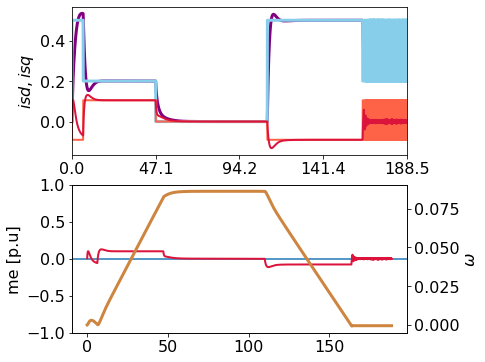

In [33]:
# a = 0.045
Tta, w, me, isd, isq, isdref, isqref = simulateSpeedingUpWithAcceleration()

# print(w)
plotDynamicForSpeedingUp(Tta, w, me, isd, isq, isdref, isqref)